In [1]:
!pip install tensorflow

In [2]:
pip install pydot

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Model

In [4]:
# Load the dataset
ref_data = pd.read_csv('normalized_reflectance_prisma.csv')

In [5]:
reflectance = ref_data.iloc[:, :234].values  # 234 bands
soc_values = ref_data.iloc[:, -2].values.reshape(-1, 1)  # SOC values
landcover_codes = ref_data.iloc[:, -1].values  # Landcover codes (float)

In [6]:
# One-hot encode the landcover codes
encoder = OneHotEncoder(sparse_output=False)
landcover_onehot = encoder.fit_transform(landcover_codes.reshape(-1, 1))

In [7]:
def gumbel_softmax(logits, temperature=1.0, hard=False):
    gumbel = -tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logits))))
    y = tf.nn.softmax((logits + gumbel) / temperature)

    if hard:
        y_hard = tf.cast(tf.equal(y, tf.reduce_max(y, axis=-1, keepdims=True)), y.dtype)
        y = tf.stop_gradient(y_hard - y) + y  # Straight-through gradient
    return y

In [8]:


def build_generator_with_gumbel(noise_dim=100, num_landcover_classes=5):
    
    noise_input = layers.Input(shape=(noise_dim,), name='noise_input')  # Noise input
    soc_input = layers.Input(shape=(1,), name='soc_input')  # SOC input
    landcover_input = layers.Input(shape=(num_landcover_classes,), name='landcover_input')  # One-hot encoded landcover input

    # Concatenate inputs
    x = layers.Concatenate()([noise_input, soc_input, landcover_input])
    
    # Fully connected layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Generate SOC output
    soc_output = layers.Dense(1, activation='linear', name='soc_output')(x)
    
    # Generate logits for landcover classification
    landcover_logits = layers.Dense(num_landcover_classes, name='landcover_logits')(x)

    # Create the model
    model = tf.keras.Model(inputs=[noise_input, soc_input, landcover_input], outputs=[soc_output, landcover_logits])
    
    return model

# Create the generator model
generator = build_generator_with_gumbel()
generator.summary()



# Plot and save model structure
plot_model(generator, to_file='generator_model.png', show_shapes=True, show_layer_names=True)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ noise_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ landcover_input (InputLayer)  │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 106)               │               0 │ noise_input[0][0],         │
│                               │                           │                 │ soc_input[0][0],           │
│                               │                           │                 │ landcover_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │          27,392 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 512)               │         131,584 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_output (Dense)            │ (None, 1)                 │             513 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ landcover_logits (Dense)      │ (None, 5)                 │           2,565 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 162,054 (633.02 KB)

 Trainable params: 162,054 (633.02 KB)

 Non-trainable params: 0 (0.00 B)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [9]:
# Define the Discriminator model
def build_discriminator_with_gumbel(num_landcover_classes=5):
    reflectance_input = layers.Input(shape=(234,), name='reflectance_input')  # Reflectance data input
    soc_input = layers.Input(shape=(1,), name='soc_input')  # SOC input (condition)
    landcover_input = layers.Input(shape=(num_landcover_classes,), name='landcover_input')  # One-hot encoded landcover input
    # Concatenate reflectance data and SOC input
    combined_input = layers.Concatenate()([reflectance_input, soc_input, landcover_input])
    
    # Fully connected layers
    x = layers.Dense(512, activation='relu')(combined_input)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    
    # Output for regression (predicting SOC)
    soc_output = layers.Dense(1, activation='linear', name='soc_output')(x)
    
    # Output for classification (Gumbel Softmax)
    class_logits = layers.Dense(num_landcover_classes)(x)  # Adjust num_classes as needed
    class_output = layers.Activation('softmax', name='class_output')(class_logits)
    
    # Create the model with two outputs: regression and classification
    model = tf.keras.Model(inputs=[reflectance_input, soc_input, landcover_input], outputs=[soc_output, class_output])
    return model

discriminator = build_discriminator_with_gumbel()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ reflectance_input             │ (None, 234)               │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ landcover_input (InputLayer)  │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 240)               │               0 │ reflectance_input[0][0],   │
│                               │                           │                 │ soc_input[0][0],           │
│                               │                           │                 │ landcover_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 512)               │         123,392 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │         131,328 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          32,896 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 5)                 │             645 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_output (Dense)            │ (None, 1)                 │             129 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ class_output (Activation)     │ (None, 5)                 │               0 │ dense_5[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 288,390 (1.10 MB)

 Trainable params: 288,390 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Print shapes before concatenation
print(f'Reflectance shape: {real_reflectance.shape}')  # Should be (10, 234)
print(f'SOC shape: {soc_real.shape}')  # Should be (10, 1)
print(f'Landcover shape: {landcover_real.shape}')  # Should be (10, 5)

# Check combined input shape in the model if needed
combined_input_shape = tf.concat([real_reflectance, soc_real, landcover_real], axis=1).shape
print(f'Combined input shape: {combined_input_shape}')  # Should be (10, 240)


Reflectance shape: (10, 234)
SOC shape: (10, 1)
Landcover shape: (10, 5)
Combined input shape: (10, 240)


In [39]:
print("real_soc_pred:", real_soc_pred.numpy())
print("landcover_logits:", landcover_logits.numpy())
print("fake_soc:", fake_soc.numpy())
print("real_landcover:", landcover_real.numpy())


real_soc_pred: [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
landcover_logits: [[-0.15823571  0.47157565  0.9558791   1.3246523  -2.3994684 ]
 [ 0.17958267 -0.2045749   0.05940407  2.2989144  -2.3385239 ]
 [ 1.3487732  -0.70002013  0.92448586  0.51983213 -1.1582942 ]
 [ 0.9964956   0.30343884  0.1874589   0.2278567  -2.8142061 ]
 [-0.04277209 -0.14612217  0.4422801   1.3477763  -2.5069711 ]
 [-0.17363732 -0.0624285   1.7520629   1.5233037  -1.8907506 ]
 [ 0.761641   -0.22467972  0.39541453  2.1728892  -2.0286703 ]
 [-0.4528278   0.81560886  0.9590594   1.7349874  -2.602525  ]
 [ 0.42820737  0.12074985  0.66164106  1.8428332  -2.4855514 ]
 [ 0.35144287 -0.3374532   2.366064   -0.31071708 -2.568056  ]]
fake_soc: [[0.44506666]
 [0.10175018]
 [0.7149519 ]
 [0.54560417]
 [0.44336858]
 [0.6554437 ]
 [0.2913368 ]
 [0.32927054]
 [0.21992774]
 [0.10619412]]
real_landcover: [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 

In [41]:


# Identify invalid values
invalid_indices = np.argwhere(np.isnan(real_reflectance) | np.isinf(real_reflectance))
if invalid_indices.size > 0:
    print("Invalid indices in real_reflectance:", invalid_indices)
else:
    print("No invalid values in real_reflectance.")


Invalid indices in real_reflectance: [[  0 230]
 [  0 231]
 [  0 232]
 [  0 233]]


In [46]:
# Parameters
noise_dim = 100  # Dimension of noise input
num_landcover_classes = landcover_onehot.shape[1]  # Number of landcover classes
epochs = 1000
batch_size = 10

# Initialize lists to store loss values
d_loss_history = []
g_loss_history = []

# Create models
generator = build_generator_with_gumbel(noise_dim, num_landcover_classes)
discriminator = build_discriminator_with_gumbel(num_landcover_classes)

# Optimizers
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Define loss function
def loss_fn(real_soc, real_landcover, fake_soc_pred, landcover_logits):
    soc_loss = tf.reduce_mean(tf.square(real_soc - fake_soc_pred))
    class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=landcover_logits, labels=real_landcover))
    return soc_loss + class_loss

# Training
for epoch in range(epochs):
    for _ in range(len(reflectance) // batch_size):
        # Sample real data
        # Example of valid random selection:
        idx = np.random.choice(real_reflectance.shape[0], batch_size, replace=False)

        real_reflectance = tf.convert_to_tensor(reflectance[idx], dtype=tf.float32)  # Shape: (10, 234)
        soc_real = tf.convert_to_tensor(soc_values[idx], dtype=tf.float32)  # Shape: (10, 1)
        landcover_real = tf.convert_to_tensor(landcover_onehot[idx], dtype=tf.float32)  # Shape: (10, 5)

        # Generate noise
        noise = np.random.normal(0, 1, (batch_size, noise_dim)).astype(np.float32)

        # Generate fake data
        noise_tensor = tf.convert_to_tensor(noise, dtype=tf.float32)  # Convert noise to tensor
        fake_soc, landcover_logits = generator([noise_tensor, soc_real, landcover_real])  # fake_soc: (10, 1), landcover_logits: (10, 5)

        # Train Discriminator
        with tf.GradientTape() as tape:
            
            # Check inputs to the discriminator
            assert np.all(np.isfinite(real_reflectance)), "real_reflectance contains invalid values"
            assert np.all(np.isfinite(soc_real)), "soc_real contains invalid values"
            assert np.all(np.isfinite(landcover_real)), "landcover_real contains invalid values"
            # Real data predictions
            real_soc_pred, landcover_logits_real = discriminator([real_reflectance, soc_real, landcover_real])
            d_loss_real = loss_fn(soc_real, landcover_real, real_soc_pred, landcover_logits_real)

            # Fake data predictions
            fake_landcover_onehot = gumbel_softmax(landcover_logits)  # Shape should be (10, num_landcover_classes)
            d_loss_fake = loss_fn(fake_soc, fake_landcover_onehot, fake_soc, landcover_logits)

            # Combine losses
            d_loss = d_loss_real + d_loss_fake
          
        # Calculate gradients and apply them
        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in grads]  # Clip gradients
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        with tf.GradientTape() as tape:
            # Generate noise for the generator
            noise = np.random.normal(0, 1, (batch_size, noise_dim)).astype(np.float32)
            noise_tensor = tf.convert_to_tensor(noise, dtype=tf.float32)  # Convert noise to tensor

            # Generate fake data
            fake_soc, landcover_logits = generator([noise_tensor, soc_real, landcover_real])  # Ensure correct inputs here

             # Calculate generator loss
            g_loss = loss_fn(soc_real, landcover_real, fake_soc, landcover_logits)  # Use fake_soc directly

        
       # Calculate gradients and apply them
        grads = tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    # Save losses at the end of each epoch
    d_loss_history.append(d_loss.numpy())
    g_loss_history.append(g_loss.numpy())
    # Print losses for monitoring
    print(f'Epoch: {epoch}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}')


Epoch: 0, D Loss: 3.072782516479492, G Loss: 1.3369239568710327
Epoch: 1, D Loss: 2.9190256595611572, G Loss: 1.2945725917816162
Epoch: 2, D Loss: 2.5396649837493896, G Loss: 1.1990718841552734
Epoch: 3, D Loss: 2.4078009128570557, G Loss: 1.1310046911239624
Epoch: 4, D Loss: 2.500805139541626, G Loss: 1.2232255935668945
Epoch: 5, D Loss: 2.586207389831543, G Loss: 1.056331992149353
Epoch: 6, D Loss: 2.365326166152954, G Loss: 1.1415441036224365
Epoch: 7, D Loss: 2.4480714797973633, G Loss: 1.017585039138794
Epoch: 8, D Loss: 2.2816832065582275, G Loss: 1.0914175510406494
Epoch: 9, D Loss: 2.455674648284912, G Loss: 1.0615801811218262
Epoch: 10, D Loss: 2.5919361114501953, G Loss: 1.100003957748413
Epoch: 11, D Loss: 2.306241512298584, G Loss: 0.9921244978904724
Epoch: 12, D Loss: 2.271252155303955, G Loss: 0.960364580154419
Epoch: 13, D Loss: 2.2050859928131104, G Loss: 1.019039273262024
Epoch: 14, D Loss: 2.0923328399658203, G Loss: 0.9186542630195618
Epoch: 15, D Loss: 2.40943241119

Epoch: 124, D Loss: 1.4925220012664795, G Loss: 0.06851208209991455
Epoch: 125, D Loss: 1.3295475244522095, G Loss: 0.03558690473437309
Epoch: 126, D Loss: 1.1491293907165527, G Loss: 0.03134337440133095
Epoch: 127, D Loss: 1.3196401596069336, G Loss: 0.06140927970409393
Epoch: 128, D Loss: 0.9677383899688721, G Loss: 0.03961639478802681
Epoch: 129, D Loss: 0.994314968585968, G Loss: 0.02737344801425934
Epoch: 130, D Loss: 1.187878131866455, G Loss: 0.04563770443201065
Epoch: 131, D Loss: 1.0213841199874878, G Loss: 0.03445049375295639
Epoch: 132, D Loss: 1.3346548080444336, G Loss: 0.03414040803909302
Epoch: 133, D Loss: 1.268359661102295, G Loss: 0.04084395989775658
Epoch: 134, D Loss: 1.1631909608840942, G Loss: 0.04276105388998985
Epoch: 135, D Loss: 1.3413819074630737, G Loss: 0.020656703040003777
Epoch: 136, D Loss: 0.9742369651794434, G Loss: 0.026128627359867096
Epoch: 137, D Loss: 0.9397973418235779, G Loss: 0.0190162044018507
Epoch: 138, D Loss: 1.1014118194580078, G Loss: 0.

Epoch: 245, D Loss: 0.9543284177780151, G Loss: 0.02757871523499489
Epoch: 246, D Loss: 0.9331082701683044, G Loss: 0.030983714386820793
Epoch: 247, D Loss: 0.9464176297187805, G Loss: 0.015631698071956635
Epoch: 248, D Loss: 0.9425097703933716, G Loss: 0.022887269034981728
Epoch: 249, D Loss: 1.086784839630127, G Loss: 0.014350755140185356
Epoch: 250, D Loss: 0.9411817789077759, G Loss: 0.01993418112397194
Epoch: 251, D Loss: 0.9412922263145447, G Loss: 0.02527182176709175
Epoch: 252, D Loss: 0.9462612867355347, G Loss: 0.019883494824171066
Epoch: 253, D Loss: 0.9214592576026917, G Loss: 0.028936536982655525
Epoch: 254, D Loss: 0.9559007883071899, G Loss: 0.021869605407118797
Epoch: 255, D Loss: 0.9444898366928101, G Loss: 0.030972588807344437
Epoch: 256, D Loss: 0.9344556331634521, G Loss: 0.009994707070291042
Epoch: 257, D Loss: 0.9710530042648315, G Loss: 0.013822988606989384
Epoch: 258, D Loss: 0.9374330043792725, G Loss: 0.008569897152483463
Epoch: 259, D Loss: 0.9222971200942993

Epoch: 365, D Loss: 0.9294067621231079, G Loss: 0.009809109382331371
Epoch: 366, D Loss: 0.9171289205551147, G Loss: 0.01587369665503502
Epoch: 367, D Loss: 0.9092414975166321, G Loss: 0.014244732446968555
Epoch: 368, D Loss: 0.9201714396476746, G Loss: 0.013814134523272514
Epoch: 369, D Loss: 1.0835572481155396, G Loss: 0.019678520038723946
Epoch: 370, D Loss: 0.9091634154319763, G Loss: 0.03298003599047661
Epoch: 371, D Loss: 0.9142735004425049, G Loss: 0.019173290580511093
Epoch: 372, D Loss: 0.9159895777702332, G Loss: 0.022049615159630775
Epoch: 373, D Loss: 0.9217042922973633, G Loss: 0.02291417308151722
Epoch: 374, D Loss: 0.9292656183242798, G Loss: 0.01794796995818615
Epoch: 375, D Loss: 0.9374218583106995, G Loss: 0.01486772671341896
Epoch: 376, D Loss: 0.9567835330963135, G Loss: 0.017675025388598442
Epoch: 377, D Loss: 0.944184422492981, G Loss: 0.02427460439503193
Epoch: 378, D Loss: 0.909142255783081, G Loss: 0.01933004893362522
Epoch: 379, D Loss: 1.565798282623291, G Lo

Epoch: 485, D Loss: 0.9274595379829407, G Loss: 0.013740884140133858
Epoch: 486, D Loss: 1.0394834280014038, G Loss: 0.024878887459635735
Epoch: 487, D Loss: 0.9705900549888611, G Loss: 0.00970043521374464
Epoch: 488, D Loss: 0.9196979999542236, G Loss: 0.025179671123623848
Epoch: 489, D Loss: 0.9090222716331482, G Loss: 0.013587245717644691
Epoch: 490, D Loss: 0.9220923185348511, G Loss: 0.020302342250943184
Epoch: 491, D Loss: 0.9101107716560364, G Loss: 0.017315896227955818
Epoch: 492, D Loss: 1.0877070426940918, G Loss: 0.0037684962153434753
Epoch: 493, D Loss: 0.91571044921875, G Loss: 0.014307556673884392
Epoch: 494, D Loss: 0.9124222993850708, G Loss: 0.01171395555138588
Epoch: 495, D Loss: 0.9285339117050171, G Loss: 0.014247092418372631
Epoch: 496, D Loss: 0.9135514497756958, G Loss: 0.012564944103360176
Epoch: 497, D Loss: 0.9185104966163635, G Loss: 0.008424902334809303
Epoch: 498, D Loss: 1.1980104446411133, G Loss: 0.006861315108835697
Epoch: 499, D Loss: 0.929214775562286

Epoch: 605, D Loss: 0.9068394303321838, G Loss: 0.011338719166815281
Epoch: 606, D Loss: 0.9114362001419067, G Loss: 0.006870290730148554
Epoch: 607, D Loss: 0.9156691431999207, G Loss: 0.008112645708024502
Epoch: 608, D Loss: 0.9088048934936523, G Loss: 0.005812967661768198
Epoch: 609, D Loss: 0.9210955500602722, G Loss: 0.005475887097418308
Epoch: 610, D Loss: 0.9073504209518433, G Loss: 0.014279773458838463
Epoch: 611, D Loss: 0.9103595614433289, G Loss: 0.010325855575501919
Epoch: 612, D Loss: 0.9134842753410339, G Loss: 0.006235990207642317
Epoch: 613, D Loss: 0.91086745262146, G Loss: 0.010094859637320042
Epoch: 614, D Loss: 0.906416654586792, G Loss: 0.007481354288756847
Epoch: 615, D Loss: 0.9357871413230896, G Loss: 0.008585364557802677
Epoch: 616, D Loss: 0.9097191691398621, G Loss: 0.0060747903771698475
Epoch: 617, D Loss: 0.9262221455574036, G Loss: 0.007679610047489405
Epoch: 618, D Loss: 1.67386794090271, G Loss: 0.014913021586835384
Epoch: 619, D Loss: 0.9193131923675537

Epoch: 725, D Loss: 0.9058882594108582, G Loss: 0.006259736604988575
Epoch: 726, D Loss: 0.9072225093841553, G Loss: 0.00944007933139801
Epoch: 727, D Loss: 0.9197052121162415, G Loss: 0.012290437705814838
Epoch: 728, D Loss: 0.9065117835998535, G Loss: 0.017135269939899445
Epoch: 729, D Loss: 0.9126762747764587, G Loss: 0.012426694855093956
Epoch: 730, D Loss: 0.9091879725456238, G Loss: 0.008201886899769306
Epoch: 731, D Loss: 0.9086965918540955, G Loss: 0.00990420300513506
Epoch: 732, D Loss: 0.9153093695640564, G Loss: 0.00669896649196744
Epoch: 733, D Loss: 0.9065623879432678, G Loss: 0.0037840656004846096
Epoch: 734, D Loss: 0.9244375824928284, G Loss: 0.005360208917409182
Epoch: 735, D Loss: 0.9144526124000549, G Loss: 0.0025669271126389503
Epoch: 736, D Loss: 0.9060127139091492, G Loss: 0.012034310959279537
Epoch: 737, D Loss: 0.9061646461486816, G Loss: 0.004359000362455845
Epoch: 738, D Loss: 0.9068089127540588, G Loss: 0.005994848906993866
Epoch: 739, D Loss: 0.9101086854934

Epoch: 844, D Loss: 0.9074999690055847, G Loss: 0.008868275210261345
Epoch: 845, D Loss: 0.9065362215042114, G Loss: 0.005863680969923735
Epoch: 846, D Loss: 0.9098961353302002, G Loss: 0.0030959961004555225
Epoch: 847, D Loss: 0.9057709574699402, G Loss: 0.015330621972680092
Epoch: 848, D Loss: 0.9076541662216187, G Loss: 0.005498747806996107
Epoch: 849, D Loss: 0.9059782028198242, G Loss: 0.006506784353405237
Epoch: 850, D Loss: 0.9061228036880493, G Loss: 0.005574659910053015
Epoch: 851, D Loss: 0.906158983707428, G Loss: 0.007165232673287392
Epoch: 852, D Loss: 0.9051440358161926, G Loss: 0.006353575270622969
Epoch: 853, D Loss: 0.9056167006492615, G Loss: 0.005196335259824991
Epoch: 854, D Loss: 0.9050701260566711, G Loss: 0.007340037729591131
Epoch: 855, D Loss: 0.9057633280754089, G Loss: 0.008911817334592342
Epoch: 856, D Loss: 0.9117897748947144, G Loss: 0.004025809932500124
Epoch: 857, D Loss: 0.9062153100967407, G Loss: 0.014374498277902603
Epoch: 858, D Loss: 0.914197862148

Epoch: 963, D Loss: 0.9059169888496399, G Loss: 0.004665791057050228
Epoch: 964, D Loss: 0.907608687877655, G Loss: 0.0043404120951890945
Epoch: 965, D Loss: 0.9056724905967712, G Loss: 0.005568557418882847
Epoch: 966, D Loss: 0.9170029163360596, G Loss: 0.004599336069077253
Epoch: 967, D Loss: 0.9051618576049805, G Loss: 0.006297745741903782
Epoch: 968, D Loss: 0.9066922664642334, G Loss: 0.00395019818097353
Epoch: 969, D Loss: 0.9061577320098877, G Loss: 0.002647991059347987
Epoch: 970, D Loss: 0.9216832518577576, G Loss: 0.004057507496327162
Epoch: 971, D Loss: 0.9055649638175964, G Loss: 0.0024211369454860687
Epoch: 972, D Loss: 0.9053767919540405, G Loss: 0.008416710421442986
Epoch: 973, D Loss: 0.90580815076828, G Loss: 0.006968935951590538
Epoch: 974, D Loss: 0.9057707786560059, G Loss: 0.0030375465285032988
Epoch: 975, D Loss: 0.9059731960296631, G Loss: 0.0033558078575879335
Epoch: 976, D Loss: 0.9063349366188049, G Loss: 0.006086335983127356
Epoch: 977, D Loss: 0.909140229225

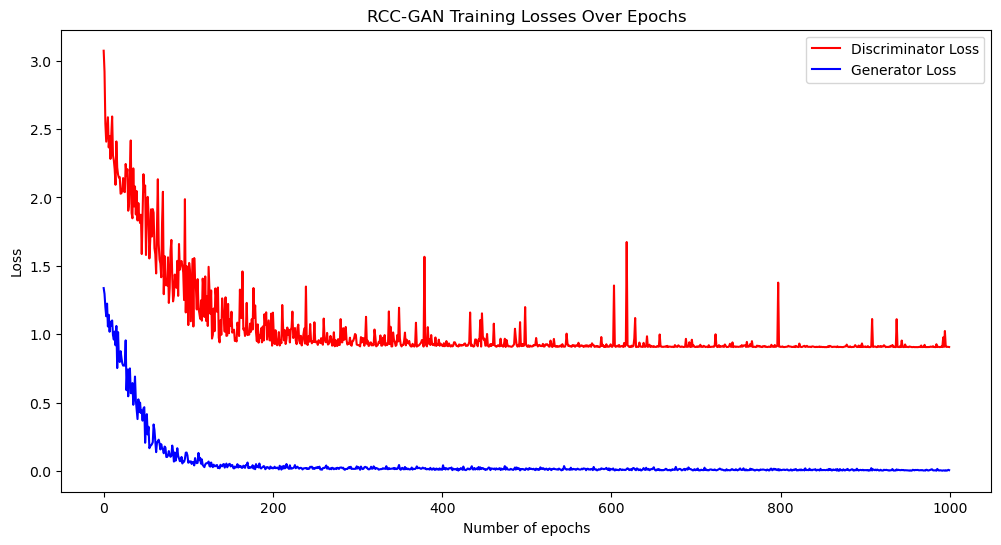

In [47]:
import matplotlib.pyplot as plt

# Plot the loss graphs after training
plt.figure(figsize=(12, 6))


plt.plot(d_loss_history, label='Discriminator Loss', color='red')
plt.plot(g_loss_history, label='Generator Loss', color='blue')
plt.title('RCC-GAN Training Losses Over Epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG file
plt.savefig('RccGAN_Training_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
pip install visualkeras pydot


In [60]:
import visualkeras
from tensorflow.keras.utils import plot_model


In [61]:
# Visualize Generator model
visualkeras.layered_view(generator, to_file='generator_model.png', legend=True)  # Saves as generator_model.png


AttributeError: 'InputLayer' object has no attribute 'output_shape'

In [56]:
import pydot
from tensorflow.keras.utils import plot_model
# Plot the generator model 
plot_model(generator, to_file='generator_model.png', show_shapes=True, show_layer_names=True)
# Plot the discriminator model
plot_model(discriminator, to_file='discriminator_model.png', show_shapes=True, show_layer_names=True) 
# For the RCCGAN model, which is a combination of the generator and discriminator 
rccgan_model = Model(inputs=[generator.input, discriminator.input], outputs=discriminator(generator.output)) 
plot_model(rccgan_model, to_file='rccgan_model.png', show_shapes=True, show_layer_names=True)  

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [64]:


import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp

# Define NNDR metric
def nndr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred) / (tf.abs(y_true) + 1e-10))  # Avoid division by zero

# Define IMS metric comparing distributions of generated and real samples
def ims_metric(real_samples, generated_samples):
    # Perform the Kolmogorov-Smirnov test to compare distributions
    stat, p_value = ks_2samp(real_samples.numpy().flatten(), generated_samples.numpy().flatten())
    return stat  # Return the KS statistic as the IMS value

# Define DCR metric
def dcr_metric(y_true, y_pred):
    return tf.reduce_mean(y_pred / (y_true + 1e-10))  # Normalize by true values

# Parameters
noise_dim = 100  # Dimension of noise input
num_landcover_classes = landcover_onehot.shape[1]  # Number of landcover classes
epochs = 1000
batch_size = 10

# Initialize lists to store loss values and metric histories
d_loss_history = []
g_loss_history = []
nndr_history = []
ims_history = []
dcr_history = []

# Create models
generator = build_generator_with_gumbel(noise_dim, num_landcover_classes)
discriminator = build_discriminator_with_gumbel(num_landcover_classes)

# Optimizers
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Define loss function
def loss_fn(real_soc, real_landcover, fake_soc_pred, landcover_logits):
    soc_loss = tf.reduce_mean(tf.square(real_soc - fake_soc_pred))
    class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=landcover_logits, labels=real_landcover))
    return soc_loss + class_loss

# Training
for epoch in range(epochs):
    for _ in range(len(reflectance) // batch_size):
        # Sample real data
        idx = np.random.choice(real_reflectance.shape[0], batch_size, replace=False)

        real_reflectance = tf.convert_to_tensor(reflectance[idx], dtype=tf.float32)  # Shape: (10, 234)
        soc_real = tf.convert_to_tensor(soc_values[idx], dtype=tf.float32)  # Shape: (10, 1)
        landcover_real = tf.convert_to_tensor(landcover_onehot[idx], dtype=tf.float32)  # Shape: (10, 5)

        # Generate noise
        noise = np.random.normal(0, 1, (batch_size, noise_dim)).astype(np.float32)

        # Generate fake data
        noise_tensor = tf.convert_to_tensor(noise, dtype=tf.float32)  # Convert noise to tensor
        fake_soc, landcover_logits = generator([noise_tensor, soc_real, landcover_real])  # fake_soc: (10, 1), landcover_logits: (10, 5)

        # Train Discriminator
        with tf.GradientTape() as tape:
            # Check inputs to the discriminator
            assert np.all(np.isfinite(real_reflectance)), "real_reflectance contains invalid values"
            assert np.all(np.isfinite(soc_real)), "soc_real contains invalid values"
            assert np.all(np.isfinite(landcover_real)), "landcover_real contains invalid values"

            # Real data predictions
            real_soc_pred, landcover_logits_real = discriminator([real_reflectance, soc_real, landcover_real])
            d_loss_real = loss_fn(soc_real, landcover_real, real_soc_pred, landcover_logits_real)

            # Fake data predictions
            fake_landcover_onehot = gumbel_softmax(landcover_logits)  # Shape should be (10, num_landcover_classes)
            d_loss_fake = loss_fn(fake_soc, fake_landcover_onehot, fake_soc, landcover_logits)

            # Combine losses
            d_loss = d_loss_real + d_loss_fake

        # Calculate gradients and apply them
        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in grads]  # Clip gradients
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            # Generate noise for the generator
            noise = np.random.normal(0, 1, (batch_size, noise_dim)).astype(np.float32)
            noise_tensor = tf.convert_to_tensor(noise, dtype=tf.float32)  # Convert noise to tensor

            # Generate fake data
            fake_soc, landcover_logits = generator([noise_tensor, soc_real, landcover_real])  # Ensure correct inputs here

            # Calculate generator loss
            g_loss = loss_fn(soc_real, landcover_real, fake_soc, landcover_logits)  # Use fake_soc directly

        # Calculate gradients and apply them
        grads = tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # Save losses at the end of each epoch
    d_loss_history.append(d_loss.numpy())
    g_loss_history.append(g_loss.numpy())

    # Compute custom metrics at the end of each epoch
    nndr_value = nndr_metric(soc_real, fake_soc).numpy()
    ims_value = ims_metric(soc_real, fake_soc)  # Compare generated and real SOC distributions
    dcr_value = dcr_metric(soc_real, fake_soc).numpy()

    nndr_history.append(nndr_value)
    ims_history.append(ims_value)
    dcr_history.append(dcr_value)

    # Print losses and metrics for monitoring
    print(f'Epoch: {epoch}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}, NNDR: {nndr_value}, IMS: {ims_value}, DCR: {dcr_value}')


Epoch: 0, D Loss: 3.1523778438568115, G Loss: 1.534478783607483, NNDR: 0.9763408899307251, IMS: 0.4, DCR: 1.6253273487091064
Epoch: 1, D Loss: 2.930158853530884, G Loss: 1.3292410373687744, NNDR: 0.8847790956497192, IMS: 0.3, DCR: 1.2638425827026367
Epoch: 2, D Loss: 2.492133140563965, G Loss: 1.3123621940612793, NNDR: 0.480948269367218, IMS: 0.3, DCR: 1.356917142868042
Epoch: 3, D Loss: 2.7659106254577637, G Loss: 1.2715095281600952, NNDR: 0.5994800925254822, IMS: 0.3, DCR: 1.236730694770813
Epoch: 4, D Loss: 2.322890520095825, G Loss: 1.1424031257629395, NNDR: 0.549930989742279, IMS: 0.3, DCR: 1.1104685068130493
Epoch: 5, D Loss: 2.551811695098877, G Loss: 1.2872368097305298, NNDR: 0.5781168937683105, IMS: 0.5, DCR: 1.0670578479766846
Epoch: 6, D Loss: 2.541170120239258, G Loss: 1.1424894332885742, NNDR: 0.9643256068229675, IMS: 0.3, DCR: 1.7746127843856812
Epoch: 7, D Loss: 2.293600082397461, G Loss: 1.202305555343628, NNDR: 0.985586941242218, IMS: 0.2, DCR: 1.6949255466461182
Epoch

Epoch: 65, D Loss: 1.5452508926391602, G Loss: 0.2288748025894165, NNDR: 0.3222147524356842, IMS: 0.4, DCR: 0.9290953874588013
Epoch: 66, D Loss: 1.4168634414672852, G Loss: 0.2523997724056244, NNDR: 0.3342110514640808, IMS: 0.3, DCR: 1.0749139785766602
Epoch: 67, D Loss: 1.444722294807434, G Loss: 0.1667153686285019, NNDR: 0.33535709977149963, IMS: 0.3, DCR: 0.7780352234840393
Epoch: 68, D Loss: 1.4193179607391357, G Loss: 0.21475109457969666, NNDR: 0.4996398985385895, IMS: 0.3, DCR: 0.92619389295578
Epoch: 69, D Loss: 1.6404342651367188, G Loss: 0.20767992734909058, NNDR: 0.4177793860435486, IMS: 0.3, DCR: 1.355869174003601
Epoch: 70, D Loss: 1.7347395420074463, G Loss: 0.19230714440345764, NNDR: 0.37824687361717224, IMS: 0.4, DCR: 1.1204136610031128
Epoch: 71, D Loss: 1.5016136169433594, G Loss: 0.1564299613237381, NNDR: 0.5416149497032166, IMS: 0.4, DCR: 1.4016352891921997
Epoch: 72, D Loss: 1.2765464782714844, G Loss: 0.2098873257637024, NNDR: 0.490742027759552, IMS: 0.4, DCR: 1.3

Epoch: 129, D Loss: 1.1032187938690186, G Loss: 0.0511353462934494, NNDR: 0.4148450493812561, IMS: 0.3, DCR: 1.213927149772644
Epoch: 130, D Loss: 1.0952285528182983, G Loss: 0.0579201802611351, NNDR: 0.36145758628845215, IMS: 0.3, DCR: 0.8013063669204712
Epoch: 131, D Loss: 1.017663836479187, G Loss: 0.02745838277041912, NNDR: 0.28714168071746826, IMS: 0.3, DCR: 1.2381675243377686
Epoch: 132, D Loss: 1.017799973487854, G Loss: 0.061284832656383514, NNDR: 0.44427984952926636, IMS: 0.3, DCR: 1.1731113195419312
Epoch: 133, D Loss: 1.10997474193573, G Loss: 0.03152003139257431, NNDR: 0.2875608801841736, IMS: 0.2, DCR: 1.2002235651016235
Epoch: 134, D Loss: 1.3742296695709229, G Loss: 0.0432615727186203, NNDR: 0.26578548550605774, IMS: 0.4, DCR: 0.9368113279342651
Epoch: 135, D Loss: 1.054248571395874, G Loss: 0.0715009868144989, NNDR: 0.3436122536659241, IMS: 0.5, DCR: 0.9553862810134888
Epoch: 136, D Loss: 1.0848079919815063, G Loss: 0.03318316489458084, NNDR: 0.28808850049972534, IMS: 0

Epoch: 193, D Loss: 1.0975525379180908, G Loss: 0.017237171530723572, NNDR: 0.2710023820400238, IMS: 0.2, DCR: 1.1261794567108154
Epoch: 194, D Loss: 1.1101891994476318, G Loss: 0.021914813667535782, NNDR: 0.30916154384613037, IMS: 0.3, DCR: 1.1660125255584717
Epoch: 195, D Loss: 0.9743192791938782, G Loss: 0.017395872622728348, NNDR: 0.2764279544353485, IMS: 0.2, DCR: 1.2005887031555176
Epoch: 196, D Loss: 1.1859432458877563, G Loss: 0.020000020042061806, NNDR: 0.33180904388427734, IMS: 0.2, DCR: 1.1786432266235352
Epoch: 197, D Loss: 0.967128336429596, G Loss: 0.01696484163403511, NNDR: 0.26018208265304565, IMS: 0.4, DCR: 0.9616351127624512
Epoch: 198, D Loss: 1.107627272605896, G Loss: 0.02305610291659832, NNDR: 0.3400377333164215, IMS: 0.3, DCR: 0.9423149228096008
Epoch: 199, D Loss: 0.9494209885597229, G Loss: 0.02602769061923027, NNDR: 0.2726200819015503, IMS: 0.2, DCR: 1.017567753791809
Epoch: 200, D Loss: 1.1123608350753784, G Loss: 0.014787162654101849, NNDR: 0.217061638832092

Epoch: 257, D Loss: 0.9243952631950378, G Loss: 0.011928227730095387, NNDR: 0.2794012725353241, IMS: 0.2, DCR: 1.1910442113876343
Epoch: 258, D Loss: 1.1067091226577759, G Loss: 0.017395738512277603, NNDR: 0.277149498462677, IMS: 0.2, DCR: 1.0557886362075806
Epoch: 259, D Loss: 0.9326072335243225, G Loss: 0.020448122173547745, NNDR: 0.3240562379360199, IMS: 0.3, DCR: 0.8766731023788452
Epoch: 260, D Loss: 0.9989553093910217, G Loss: 0.015439176931977272, NNDR: 0.22790415585041046, IMS: 0.3, DCR: 0.908120334148407
Epoch: 261, D Loss: 0.913894534111023, G Loss: 0.010030870325863361, NNDR: 0.22466953098773956, IMS: 0.2, DCR: 1.1313190460205078
Epoch: 262, D Loss: 1.000037431716919, G Loss: 0.021476978436112404, NNDR: 0.3831205368041992, IMS: 0.3, DCR: 1.2034330368041992
Epoch: 263, D Loss: 0.941396951675415, G Loss: 0.02462787926197052, NNDR: 0.3307209610939026, IMS: 0.4, DCR: 0.8733305931091309
Epoch: 264, D Loss: 0.9573051929473877, G Loss: 0.016735900193452835, NNDR: 0.3411880433559418

Epoch: 321, D Loss: 0.9606128334999084, G Loss: 0.031226182356476784, NNDR: 0.2875889837741852, IMS: 0.4, DCR: 0.7124110460281372
Epoch: 322, D Loss: 0.9544457197189331, G Loss: 0.020328205078840256, NNDR: 0.35561639070510864, IMS: 0.3, DCR: 1.2505663633346558
Epoch: 323, D Loss: 0.925216555595398, G Loss: 0.015972940251231194, NNDR: 0.2618322968482971, IMS: 0.3, DCR: 1.0639653205871582
Epoch: 324, D Loss: 0.9377084970474243, G Loss: 0.014500833116471767, NNDR: 0.1982915699481964, IMS: 0.3, DCR: 0.8306897878646851
Epoch: 325, D Loss: 0.9404028654098511, G Loss: 0.025664659217000008, NNDR: 0.38014814257621765, IMS: 0.3, DCR: 1.3267086744308472
Epoch: 326, D Loss: 0.9828312993049622, G Loss: 0.02488357201218605, NNDR: 0.32539698481559753, IMS: 0.3, DCR: 0.9272791743278503
Epoch: 327, D Loss: 1.0013679265975952, G Loss: 0.006961466744542122, NNDR: 0.16078628599643707, IMS: 0.2, DCR: 1.0974628925323486
Epoch: 328, D Loss: 1.0031843185424805, G Loss: 0.02957005798816681, NNDR: 0.43670693039

Epoch: 385, D Loss: 0.9079071283340454, G Loss: 0.020217381417751312, NNDR: 0.2590416967868805, IMS: 0.2, DCR: 0.9395567178726196
Epoch: 386, D Loss: 0.9803824424743652, G Loss: 0.022596212103962898, NNDR: 0.3741188645362854, IMS: 0.2, DCR: 1.1424063444137573
Epoch: 387, D Loss: 0.9180845022201538, G Loss: 0.011964569799602032, NNDR: 0.24480268359184265, IMS: 0.2, DCR: 1.039787769317627
Epoch: 388, D Loss: 0.9234986305236816, G Loss: 0.014049675315618515, NNDR: 0.2955777943134308, IMS: 0.2, DCR: 1.2006607055664062
Epoch: 389, D Loss: 0.9226576685905457, G Loss: 0.019314821809530258, NNDR: 0.3156208395957947, IMS: 0.2, DCR: 1.040893316268921
Epoch: 390, D Loss: 0.9145036339759827, G Loss: 0.01635001413524151, NNDR: 0.3082576096057892, IMS: 0.3, DCR: 0.9395644068717957
Epoch: 391, D Loss: 0.9132317304611206, G Loss: 0.010207252576947212, NNDR: 0.23808923363685608, IMS: 0.3, DCR: 1.0645418167114258
Epoch: 392, D Loss: 0.9671589136123657, G Loss: 0.019329067319631577, NNDR: 0.2498927116394

Epoch: 449, D Loss: 0.9278415441513062, G Loss: 0.011976225301623344, NNDR: 0.2512966990470886, IMS: 0.2, DCR: 1.0819212198257446
Epoch: 450, D Loss: 0.9106108546257019, G Loss: 0.024446114897727966, NNDR: 0.2539161443710327, IMS: 0.3, DCR: 0.9569052457809448
Epoch: 451, D Loss: 0.9609848856925964, G Loss: 0.011448519304394722, NNDR: 0.2169506996870041, IMS: 0.2, DCR: 1.128926396369934
Epoch: 452, D Loss: 0.9167881011962891, G Loss: 0.010734735056757927, NNDR: 0.24309344589710236, IMS: 0.2, DCR: 1.0604913234710693
Epoch: 453, D Loss: 0.9121095538139343, G Loss: 0.022224655374884605, NNDR: 0.38983359932899475, IMS: 0.3, DCR: 1.0407861471176147
Epoch: 454, D Loss: 0.9128405451774597, G Loss: 0.010506088845431805, NNDR: 0.21683302521705627, IMS: 0.2, DCR: 0.9975444674491882
Epoch: 455, D Loss: 0.9785478115081787, G Loss: 0.00941721722483635, NNDR: 0.19480375945568085, IMS: 0.3, DCR: 0.9794629812240601
Epoch: 456, D Loss: 0.9096937775611877, G Loss: 0.019814811646938324, NNDR: 0.3377719521

Epoch: 513, D Loss: 0.9174951314926147, G Loss: 0.0144721744582057, NNDR: 0.3100985586643219, IMS: 0.2, DCR: 1.1925804615020752
Epoch: 514, D Loss: 0.9122866988182068, G Loss: 0.01927889697253704, NNDR: 0.2501528561115265, IMS: 0.3, DCR: 0.8670148849487305
Epoch: 515, D Loss: 0.9123334288597107, G Loss: 0.011077571660280228, NNDR: 0.20730705559253693, IMS: 0.3, DCR: 1.0132986307144165
Epoch: 516, D Loss: 0.9082204103469849, G Loss: 0.021506795659661293, NNDR: 0.3818379044532776, IMS: 0.3, DCR: 1.3169934749603271
Epoch: 517, D Loss: 0.9089844822883606, G Loss: 0.024468014016747475, NNDR: 0.28241127729415894, IMS: 0.4, DCR: 0.7708855867385864
Epoch: 518, D Loss: 0.9075399041175842, G Loss: 0.01708676479756832, NNDR: 0.2198454588651657, IMS: 0.4, DCR: 0.8550006151199341
Epoch: 519, D Loss: 0.917569637298584, G Loss: 0.01254973653703928, NNDR: 0.21001191437244415, IMS: 0.4, DCR: 0.8369825482368469
Epoch: 520, D Loss: 0.9072705507278442, G Loss: 0.011323384940624237, NNDR: 0.251616656780242

Epoch: 577, D Loss: 0.9092193841934204, G Loss: 0.014752696268260479, NNDR: 0.3114853799343109, IMS: 0.2, DCR: 1.1577577590942383
Epoch: 578, D Loss: 0.9161738157272339, G Loss: 0.0064597479067742825, NNDR: 0.2017751932144165, IMS: 0.2, DCR: 1.0096722841262817
Epoch: 579, D Loss: 0.9130863547325134, G Loss: 0.015920640900731087, NNDR: 0.3084780275821686, IMS: 0.2, DCR: 1.214838981628418
Epoch: 580, D Loss: 0.9206827282905579, G Loss: 0.01879291608929634, NNDR: 0.23418490588665009, IMS: 0.3, DCR: 0.8125801086425781
Epoch: 581, D Loss: 0.922048807144165, G Loss: 0.0032599528785794973, NNDR: 0.09987445920705795, IMS: 0.2, DCR: 0.9976658821105957
Epoch: 582, D Loss: 1.0067418813705444, G Loss: 0.010605732910335064, NNDR: 0.29611095786094666, IMS: 0.3, DCR: 1.2298088073730469
Epoch: 583, D Loss: 0.9108663201332092, G Loss: 0.025347577407956123, NNDR: 0.4393077790737152, IMS: 0.3, DCR: 1.3824807405471802
Epoch: 584, D Loss: 0.9234046936035156, G Loss: 0.021690048277378082, NNDR: 0.2993641197

Epoch: 640, D Loss: 0.9067412614822388, G Loss: 0.013350054621696472, NNDR: 0.2640281617641449, IMS: 0.3, DCR: 0.863988995552063
Epoch: 641, D Loss: 0.9222333431243896, G Loss: 0.017329875379800797, NNDR: 0.20293545722961426, IMS: 0.3, DCR: 0.8253332376480103
Epoch: 642, D Loss: 0.9128113389015198, G Loss: 0.004579567816108465, NNDR: 0.14975975453853607, IMS: 0.2, DCR: 0.8546720743179321
Epoch: 643, D Loss: 0.9059675335884094, G Loss: 0.007898861542344093, NNDR: 0.13043880462646484, IMS: 0.2, DCR: 0.9468055963516235
Epoch: 644, D Loss: 0.9147889018058777, G Loss: 0.016248131170868874, NNDR: 0.32781845331192017, IMS: 0.3, DCR: 1.176410436630249
Epoch: 645, D Loss: 0.9077091217041016, G Loss: 0.005640885792672634, NNDR: 0.16597530245780945, IMS: 0.2, DCR: 1.0212059020996094
Epoch: 646, D Loss: 0.908287763595581, G Loss: 0.006878694985061884, NNDR: 0.2276899367570877, IMS: 0.2, DCR: 1.1599045991897583
Epoch: 647, D Loss: 0.910706102848053, G Loss: 0.010576759465038776, NNDR: 0.25363355875

Epoch: 704, D Loss: 0.9083184003829956, G Loss: 0.007442679721862078, NNDR: 0.21876759827136993, IMS: 0.2, DCR: 1.1350606679916382
Epoch: 705, D Loss: 0.9080386161804199, G Loss: 0.009321917779743671, NNDR: 0.19758222997188568, IMS: 0.3, DCR: 0.8722552061080933
Epoch: 706, D Loss: 0.9093979001045227, G Loss: 0.008889884687960148, NNDR: 0.24553778767585754, IMS: 0.2, DCR: 0.8448488116264343
Epoch: 707, D Loss: 0.905799925327301, G Loss: 0.010108333081007004, NNDR: 0.16857868432998657, IMS: 0.3, DCR: 0.9389628171920776
Epoch: 708, D Loss: 0.921096682548523, G Loss: 0.002885289955884218, NNDR: 0.123032346367836, IMS: 0.2, DCR: 1.0952720642089844
Epoch: 709, D Loss: 0.9070591926574707, G Loss: 0.004362335428595543, NNDR: 0.14714999496936798, IMS: 0.2, DCR: 1.0685980319976807
Epoch: 710, D Loss: 0.9254468083381653, G Loss: 0.004459884949028492, NNDR: 0.1837950199842453, IMS: 0.2, DCR: 1.1051242351531982
Epoch: 711, D Loss: 0.9078251719474792, G Loss: 0.00256105768494308, NNDR: 0.09864725172

Epoch: 768, D Loss: 0.9066480398178101, G Loss: 0.006964925676584244, NNDR: 0.20641367137432098, IMS: 0.2, DCR: 1.0966103076934814
Epoch: 769, D Loss: 0.906836748123169, G Loss: 0.01998792216181755, NNDR: 0.31418830156326294, IMS: 0.3, DCR: 1.104892373085022
Epoch: 770, D Loss: 0.9087662100791931, G Loss: 0.009030410088598728, NNDR: 0.165951669216156, IMS: 0.2, DCR: 0.9748083353042603
Epoch: 771, D Loss: 0.9235008358955383, G Loss: 0.005664756055921316, NNDR: 0.16574253141880035, IMS: 0.2, DCR: 1.0917718410491943
Epoch: 772, D Loss: 0.906539797782898, G Loss: 0.009499276988208294, NNDR: 0.26355382800102234, IMS: 0.2, DCR: 1.0066149234771729
Epoch: 773, D Loss: 0.9145386219024658, G Loss: 0.007024162448942661, NNDR: 0.16671878099441528, IMS: 0.2, DCR: 0.9135257601737976
Epoch: 774, D Loss: 0.9051215052604675, G Loss: 0.015421350486576557, NNDR: 0.3402863144874573, IMS: 0.3, DCR: 1.2549054622650146
Epoch: 775, D Loss: 0.9096863269805908, G Loss: 0.007733226288110018, NNDR: 0.201931163668

Epoch: 831, D Loss: 0.9053573608398438, G Loss: 0.006437916774302721, NNDR: 0.16725274920463562, IMS: 0.2, DCR: 1.069091558456421
Epoch: 832, D Loss: 0.9072229266166687, G Loss: 0.005685123614966869, NNDR: 0.21178512275218964, IMS: 0.2, DCR: 1.0584924221038818
Epoch: 833, D Loss: 0.90678870677948, G Loss: 0.004568356089293957, NNDR: 0.11329080164432526, IMS: 0.2, DCR: 0.952572226524353
Epoch: 834, D Loss: 0.9059903025627136, G Loss: 0.009803379885852337, NNDR: 0.20666560530662537, IMS: 0.2, DCR: 0.8773792386054993
Epoch: 835, D Loss: 0.9454926252365112, G Loss: 0.012632302939891815, NNDR: 0.24350681900978088, IMS: 0.3, DCR: 0.7776786684989929
Epoch: 836, D Loss: 0.9094667434692383, G Loss: 0.004948366899043322, NNDR: 0.187565416097641, IMS: 0.2, DCR: 1.0514860153198242
Epoch: 837, D Loss: 0.9220917224884033, G Loss: 0.003720123553648591, NNDR: 0.125006765127182, IMS: 0.2, DCR: 1.0169378519058228
Epoch: 838, D Loss: 0.9155673980712891, G Loss: 0.006429530214518309, NNDR: 0.2035947293043

Epoch: 894, D Loss: 0.9065198302268982, G Loss: 0.005014912225306034, NNDR: 0.14322234690189362, IMS: 0.2, DCR: 1.000779390335083
Epoch: 895, D Loss: 0.9060567617416382, G Loss: 0.013781939633190632, NNDR: 0.23831704258918762, IMS: 0.3, DCR: 1.1958138942718506
Epoch: 896, D Loss: 0.9067971706390381, G Loss: 0.007930154912173748, NNDR: 0.21123120188713074, IMS: 0.2, DCR: 0.9616256952285767
Epoch: 897, D Loss: 0.9057580232620239, G Loss: 0.006183376535773277, NNDR: 0.1994132697582245, IMS: 0.3, DCR: 1.19488525390625
Epoch: 898, D Loss: 0.9063891768455505, G Loss: 0.005750629585236311, NNDR: 0.18352541327476501, IMS: 0.2, DCR: 1.120404839515686
Epoch: 899, D Loss: 0.9254435300827026, G Loss: 0.004749211482703686, NNDR: 0.17075960338115692, IMS: 0.2, DCR: 1.076845645904541
Epoch: 900, D Loss: 0.9060693979263306, G Loss: 0.003574328264221549, NNDR: 0.12492464482784271, IMS: 0.2, DCR: 0.909275233745575
Epoch: 901, D Loss: 0.9090904593467712, G Loss: 0.005649219732731581, NNDR: 0.163560792803

Epoch: 957, D Loss: 0.9082679152488708, G Loss: 0.004030731040984392, NNDR: 0.15631012618541718, IMS: 0.2, DCR: 1.154780626296997
Epoch: 958, D Loss: 0.9067751169204712, G Loss: 0.004445631522685289, NNDR: 0.158664733171463, IMS: 0.2, DCR: 1.0437215566635132
Epoch: 959, D Loss: 0.906591534614563, G Loss: 0.003071599407121539, NNDR: 0.13631917536258698, IMS: 0.2, DCR: 1.0936208963394165
Epoch: 960, D Loss: 0.9057062268257141, G Loss: 0.0074303350411355495, NNDR: 0.21406587958335876, IMS: 0.2, DCR: 1.1558269262313843
Epoch: 961, D Loss: 0.9058346748352051, G Loss: 0.010391905903816223, NNDR: 0.22719666361808777, IMS: 0.2, DCR: 1.1878662109375
Epoch: 962, D Loss: 1.0000789165496826, G Loss: 0.003130208468064666, NNDR: 0.11197173595428467, IMS: 0.2, DCR: 0.9649871587753296
Epoch: 963, D Loss: 0.9056431651115417, G Loss: 0.002440790878608823, NNDR: 0.12679767608642578, IMS: 0.2, DCR: 1.0100592374801636
Epoch: 964, D Loss: 0.9051246643066406, G Loss: 0.003917493391782045, NNDR: 0.18266908824

Epoch: 0, D Loss: 2.903010368347168, G Loss: 1.4542534351348877, SOC NNDR: 0.7528252601623535, SOC IMS: 0.2, SOC DCR: 1.2564852237701416, Landcover NNDR: 1172829440.0, Landcover IMS: 0.8, Landcover DCR: 1172829440.0
Epoch: 1, D Loss: 2.8691422939300537, G Loss: 1.157546877861023, SOC NNDR: 0.6302279233932495, SOC IMS: 0.2, SOC DCR: 1.2859523296356201, Landcover NNDR: 1000869504.0, Landcover IMS: 0.8, Landcover DCR: 1000869504.0
Epoch: 2, D Loss: 2.6404876708984375, G Loss: 1.1560472249984741, SOC NNDR: 0.7680217027664185, SOC IMS: 0.3, SOC DCR: 1.2059684991836548, Landcover NNDR: 1075234432.0, Landcover IMS: 0.8, Landcover DCR: 1075234432.0
Epoch: 3, D Loss: 2.6093497276306152, G Loss: 1.1377387046813965, SOC NNDR: 0.6677732467651367, SOC IMS: 0.2, SOC DCR: 1.3881595134735107, Landcover NNDR: 1521158400.0, Landcover IMS: 0.8, Landcover DCR: 1521158400.0
Epoch: 4, D Loss: 2.6843295097351074, G Loss: 1.2098639011383057, SOC NNDR: 0.6782041788101196, SOC IMS: 0.3, SOC DCR: 1.3547312021255

Epoch: 38, D Loss: 2.2721338272094727, G Loss: 0.5669158697128296, SOC NNDR: 0.5828176736831665, SOC IMS: 0.2, SOC DCR: 1.3962956666946411, Landcover NNDR: 1071579776.0, Landcover IMS: 0.8, Landcover DCR: 1071579776.0
Epoch: 39, D Loss: 2.2302441596984863, G Loss: 0.6921749711036682, SOC NNDR: 0.5224074125289917, SOC IMS: 0.3, SOC DCR: 1.1388890743255615, Landcover NNDR: 989842368.0, Landcover IMS: 0.8, Landcover DCR: 989842368.0
Epoch: 40, D Loss: 1.9583743810653687, G Loss: 0.5189197659492493, SOC NNDR: 0.4923250079154968, SOC IMS: 0.3, SOC DCR: 0.9758780598640442, Landcover NNDR: 975875712.0, Landcover IMS: 0.8, Landcover DCR: 975875712.0
Epoch: 41, D Loss: 1.9843742847442627, G Loss: 0.49452322721481323, SOC NNDR: 0.4835122525691986, SOC IMS: 0.5, SOC DCR: 1.101829171180725, Landcover NNDR: 826956736.0, Landcover IMS: 0.8, Landcover DCR: 826956736.0
Epoch: 42, D Loss: 2.155639886856079, G Loss: 0.4764516353607178, SOC NNDR: 0.22257006168365479, SOC IMS: 0.3, SOC DCR: 0.940557122230

Epoch: 76, D Loss: 1.3037586212158203, G Loss: 0.24643364548683167, SOC NNDR: 0.3636130690574646, SOC IMS: 0.3, SOC DCR: 1.2281863689422607, Landcover NNDR: 310041184.0, Landcover IMS: 0.8, Landcover DCR: 310041184.0
Epoch: 77, D Loss: 1.5515248775482178, G Loss: 0.16278189420700073, SOC NNDR: 0.42076486349105835, SOC IMS: 0.2, SOC DCR: 1.1361850500106812, Landcover NNDR: 419153056.0, Landcover IMS: 0.8, Landcover DCR: 419153056.0
Epoch: 78, D Loss: 1.444122552871704, G Loss: 0.18862412869930267, SOC NNDR: 0.3829094469547272, SOC IMS: 0.2, SOC DCR: 1.099367380142212, Landcover NNDR: 356934048.0, Landcover IMS: 0.8, Landcover DCR: 356934048.0
Epoch: 79, D Loss: 1.4527268409729004, G Loss: 0.14120544493198395, SOC NNDR: 0.30484282970428467, SOC IMS: 0.3, SOC DCR: 0.8676329851150513, Landcover NNDR: 354794752.0, Landcover IMS: 0.8, Landcover DCR: 354794752.0
Epoch: 80, D Loss: 1.823407530784607, G Loss: 0.13701128959655762, SOC NNDR: 0.5409187078475952, SOC IMS: 0.3, SOC DCR: 1.2385643720

Epoch: 114, D Loss: 1.2957348823547363, G Loss: 0.048926256597042084, SOC NNDR: 0.3751135766506195, SOC IMS: 0.4, SOC DCR: 0.8529585003852844, Landcover NNDR: 176183072.0, Landcover IMS: 0.8, Landcover DCR: 176183072.0
Epoch: 115, D Loss: 0.9885622262954712, G Loss: 0.0293559692800045, SOC NNDR: 0.18665827810764313, SOC IMS: 0.3, SOC DCR: 1.000763177871704, Landcover NNDR: 23484456.0, Landcover IMS: 0.8, Landcover DCR: 23484456.0
Epoch: 116, D Loss: 1.298183798789978, G Loss: 0.05932612717151642, SOC NNDR: 0.3573196530342102, SOC IMS: 0.3, SOC DCR: 1.2054474353790283, Landcover NNDR: 204784320.0, Landcover IMS: 0.8, Landcover DCR: 204784320.0
Epoch: 117, D Loss: 0.9916433691978455, G Loss: 0.05138746649026871, SOC NNDR: 0.3031955063343048, SOC IMS: 0.2, SOC DCR: 0.9642766714096069, Landcover NNDR: 30753944.0, Landcover IMS: 0.8, Landcover DCR: 30753944.0
Epoch: 118, D Loss: 1.4236773252487183, G Loss: 0.07690192013978958, SOC NNDR: 0.4524628520011902, SOC IMS: 0.3, SOC DCR: 1.180975079

Epoch: 152, D Loss: 0.9552130103111267, G Loss: 0.040086716413497925, SOC NNDR: 0.37261962890625, SOC IMS: 0.2, SOC DCR: 1.0526715517044067, Landcover NNDR: 15906949.0, Landcover IMS: 0.8, Landcover DCR: 15906949.0
Epoch: 153, D Loss: 0.9713889360427856, G Loss: 0.04488198831677437, SOC NNDR: 0.4647604823112488, SOC IMS: 0.2, SOC DCR: 0.9776839017868042, Landcover NNDR: 22237146.0, Landcover IMS: 0.8, Landcover DCR: 22237146.0
Epoch: 154, D Loss: 1.0522732734680176, G Loss: 0.038546398282051086, SOC NNDR: 0.3431262969970703, SOC IMS: 0.4, SOC DCR: 1.0335718393325806, Landcover NNDR: 48332724.0, Landcover IMS: 0.8, Landcover DCR: 48332724.0
Epoch: 155, D Loss: 0.976229727268219, G Loss: 0.028621673583984375, SOC NNDR: 0.34836044907569885, SOC IMS: 0.4, SOC DCR: 0.8783295750617981, Landcover NNDR: 19440366.0, Landcover IMS: 0.8, Landcover DCR: 19440368.0
Epoch: 156, D Loss: 0.9393476247787476, G Loss: 0.03569547086954117, SOC NNDR: 0.41958436369895935, SOC IMS: 0.3, SOC DCR: 1.0761926174

Epoch: 190, D Loss: 1.1426124572753906, G Loss: 0.02344883419573307, SOC NNDR: 0.2951863706111908, SOC IMS: 0.3, SOC DCR: 0.7875305414199829, Landcover NNDR: 92239712.0, Landcover IMS: 0.8, Landcover DCR: 92239712.0
Epoch: 191, D Loss: 1.246970295906067, G Loss: 0.027918025851249695, SOC NNDR: 0.38354817032814026, SOC IMS: 0.3, SOC DCR: 1.278015375137329, Landcover NNDR: 83325376.0, Landcover IMS: 0.8, Landcover DCR: 83325376.0
Epoch: 192, D Loss: 0.9328860640525818, G Loss: 0.026541654020547867, SOC NNDR: 0.3317700922489166, SOC IMS: 0.2, SOC DCR: 1.0896618366241455, Landcover NNDR: 7502178.0, Landcover IMS: 0.8, Landcover DCR: 7502178.0
Epoch: 193, D Loss: 0.9960557818412781, G Loss: 0.038068827241659164, SOC NNDR: 0.43382588028907776, SOC IMS: 0.4, SOC DCR: 1.3403112888336182, Landcover NNDR: 29062686.0, Landcover IMS: 0.8, Landcover DCR: 29062690.0
Epoch: 194, D Loss: 1.0554728507995605, G Loss: 0.01930035650730133, SOC NNDR: 0.23014232516288757, SOC IMS: 0.4, SOC DCR: 0.8610631823

Epoch: 228, D Loss: 1.428375482559204, G Loss: 0.02105923555791378, SOC NNDR: 0.29967576265335083, SOC IMS: 0.3, SOC DCR: 0.8637351989746094, Landcover NNDR: 119622960.0, Landcover IMS: 0.8, Landcover DCR: 119622960.0
Epoch: 229, D Loss: 0.9710400700569153, G Loss: 0.035660579800605774, SOC NNDR: 0.3410674035549164, SOC IMS: 0.3, SOC DCR: 1.2804533243179321, Landcover NNDR: 22601400.0, Landcover IMS: 0.8, Landcover DCR: 22601400.0
Epoch: 230, D Loss: 1.0466773509979248, G Loss: 0.017919234931468964, SOC NNDR: 0.3087937831878662, SOC IMS: 0.3, SOC DCR: 1.0837169885635376, Landcover NNDR: 40959420.0, Landcover IMS: 0.8, Landcover DCR: 40959420.0
Epoch: 231, D Loss: 1.2878315448760986, G Loss: 0.020415551960468292, SOC NNDR: 0.2998765707015991, SOC IMS: 0.2, SOC DCR: 1.146714687347412, Landcover NNDR: 119881080.0, Landcover IMS: 0.8, Landcover DCR: 119881080.0
Epoch: 232, D Loss: 0.9478110671043396, G Loss: 0.025684446096420288, SOC NNDR: 0.23764093220233917, SOC IMS: 0.4, SOC DCR: 0.8034

Epoch: 266, D Loss: 0.9551882743835449, G Loss: 0.015221692621707916, SOC NNDR: 0.2813158631324768, SOC IMS: 0.2, SOC DCR: 1.110830545425415, Landcover NNDR: 12459945.0, Landcover IMS: 0.8, Landcover DCR: 12459945.0
Epoch: 267, D Loss: 1.0666236877441406, G Loss: 0.017456816509366035, SOC NNDR: 0.30023589730262756, SOC IMS: 0.2, SOC DCR: 1.042685866355896, Landcover NNDR: 69401232.0, Landcover IMS: 0.8, Landcover DCR: 69401232.0
Epoch: 268, D Loss: 1.0108420848846436, G Loss: 0.039490941911935806, SOC NNDR: 0.5558744072914124, SOC IMS: 0.4, SOC DCR: 1.5256242752075195, Landcover NNDR: 33506028.0, Landcover IMS: 0.8, Landcover DCR: 33506028.0
Epoch: 269, D Loss: 0.9975860714912415, G Loss: 0.010655829682946205, SOC NNDR: 0.14530594646930695, SOC IMS: 0.2, SOC DCR: 0.8993428945541382, Landcover NNDR: 32048422.0, Landcover IMS: 0.8, Landcover DCR: 32048422.0
Epoch: 270, D Loss: 0.9557986855506897, G Loss: 0.02135959081351757, SOC NNDR: 0.2608086168766022, SOC IMS: 0.3, SOC DCR: 0.95837461

Epoch: 304, D Loss: 0.9161362648010254, G Loss: 0.02692771703004837, SOC NNDR: 0.4371107220649719, SOC IMS: 0.4, SOC DCR: 1.4275500774383545, Landcover NNDR: 2838254.0, Landcover IMS: 0.8, Landcover DCR: 2838254.5
Epoch: 305, D Loss: 0.9301554560661316, G Loss: 0.02884402498602867, SOC NNDR: 0.3561211824417114, SOC IMS: 0.3, SOC DCR: 1.0568994283676147, Landcover NNDR: 6986130.0, Landcover IMS: 0.8, Landcover DCR: 6986130.0
Epoch: 306, D Loss: 0.9304665923118591, G Loss: 0.04863819479942322, SOC NNDR: 0.5444943904876709, SOC IMS: 0.4, SOC DCR: 1.507465124130249, Landcover NNDR: 7102689.5, Landcover IMS: 0.8, Landcover DCR: 7102689.5
Epoch: 307, D Loss: 0.9219985008239746, G Loss: 0.025655725970864296, SOC NNDR: 0.4312278628349304, SOC IMS: 0.3, SOC DCR: 1.3581937551498413, Landcover NNDR: 3336917.0, Landcover IMS: 0.8, Landcover DCR: 3336917.5
Epoch: 308, D Loss: 0.9272667765617371, G Loss: 0.03164457902312279, SOC NNDR: 0.3437778353691101, SOC IMS: 0.3, SOC DCR: 0.9058622121810913, La

Epoch: 343, D Loss: 0.9157214760780334, G Loss: 0.016161859035491943, SOC NNDR: 0.33332017064094543, SOC IMS: 0.2, SOC DCR: 1.1468373537063599, Landcover NNDR: 2427045.0, Landcover IMS: 0.8, Landcover DCR: 2427045.5
Epoch: 344, D Loss: 0.9141103625297546, G Loss: 0.021963538601994514, SOC NNDR: 0.30769529938697815, SOC IMS: 0.3, SOC DCR: 1.2670456171035767, Landcover NNDR: 1413536.75, Landcover IMS: 0.8, Landcover DCR: 1413537.0
Epoch: 345, D Loss: 0.9169299602508545, G Loss: 0.021368972957134247, SOC NNDR: 0.37318193912506104, SOC IMS: 0.3, SOC DCR: 1.2332130670547485, Landcover NNDR: 2353245.5, Landcover IMS: 0.8, Landcover DCR: 2353245.5
Epoch: 346, D Loss: 0.9418776631355286, G Loss: 0.027860473841428757, SOC NNDR: 0.47076359391212463, SOC IMS: 0.4, SOC DCR: 1.4048311710357666, Landcover NNDR: 12253427.0, Landcover IMS: 0.8, Landcover DCR: 12253427.0
Epoch: 347, D Loss: 1.023575782775879, G Loss: 0.02165987342596054, SOC NNDR: 0.2651936113834381, SOC IMS: 0.3, SOC DCR: 0.8219271898

Epoch: 381, D Loss: 0.916671633720398, G Loss: 0.013159722089767456, SOC NNDR: 0.2816166877746582, SOC IMS: 0.2, SOC DCR: 1.1513245105743408, Landcover NNDR: 3277799.25, Landcover IMS: 0.8, Landcover DCR: 3277799.75
Epoch: 382, D Loss: 0.924616813659668, G Loss: 0.02603141777217388, SOC NNDR: 0.30837589502334595, SOC IMS: 0.3, SOC DCR: 0.8562671542167664, Landcover NNDR: 3306457.25, Landcover IMS: 0.8, Landcover DCR: 3306457.5
Epoch: 383, D Loss: 0.9188275933265686, G Loss: 0.008549587801098824, SOC NNDR: 0.1678520143032074, SOC IMS: 0.3, SOC DCR: 0.9235101938247681, Landcover NNDR: 3039164.75, Landcover IMS: 0.8, Landcover DCR: 3039165.0
Epoch: 384, D Loss: 0.9258098602294922, G Loss: 0.014260840602219105, SOC NNDR: 0.27247530221939087, SOC IMS: 0.3, SOC DCR: 1.117704153060913, Landcover NNDR: 5180778.5, Landcover IMS: 0.8, Landcover DCR: 5180778.5
Epoch: 385, D Loss: 0.9111329913139343, G Loss: 0.012320484034717083, SOC NNDR: 0.299307644367218, SOC IMS: 0.3, SOC DCR: 1.18526268005371

Epoch: 419, D Loss: 0.921177089214325, G Loss: 0.01658165454864502, SOC NNDR: 0.2967994809150696, SOC IMS: 0.3, SOC DCR: 1.0154536962509155, Landcover NNDR: 4326281.5, Landcover IMS: 0.8, Landcover DCR: 4326281.5
Epoch: 420, D Loss: 0.9117158055305481, G Loss: 0.007638328708708286, SOC NNDR: 0.1925688534975052, SOC IMS: 0.3, SOC DCR: 1.0976580381393433, Landcover NNDR: 1653995.5, Landcover IMS: 0.8, Landcover DCR: 1653995.625
Epoch: 421, D Loss: 0.9164525270462036, G Loss: 0.009240963496267796, SOC NNDR: 0.25170421600341797, SOC IMS: 0.2, SOC DCR: 1.0613659620285034, Landcover NNDR: 2746126.0, Landcover IMS: 0.8, Landcover DCR: 2746126.5
Epoch: 422, D Loss: 0.9236976504325867, G Loss: 0.006319617852568626, SOC NNDR: 0.18745088577270508, SOC IMS: 0.2, SOC DCR: 1.0143330097198486, Landcover NNDR: 5531656.5, Landcover IMS: 0.8, Landcover DCR: 5531656.5
Epoch: 423, D Loss: 0.9138842821121216, G Loss: 0.01837465912103653, SOC NNDR: 0.33135706186294556, SOC IMS: 0.2, SOC DCR: 1.2716846466064

Epoch: 457, D Loss: 0.9161519408226013, G Loss: 0.018928654491901398, SOC NNDR: 0.2953820824623108, SOC IMS: 0.2, SOC DCR: 1.0152102708816528, Landcover NNDR: 2830188.5, Landcover IMS: 0.8, Landcover DCR: 2830189.0
Epoch: 458, D Loss: 0.9552475214004517, G Loss: 0.01818901300430298, SOC NNDR: 0.3613497316837311, SOC IMS: 0.3, SOC DCR: 1.2756993770599365, Landcover NNDR: 11315259.0, Landcover IMS: 0.8, Landcover DCR: 11315259.0
Epoch: 459, D Loss: 0.9075894355773926, G Loss: 0.012256520800292492, SOC NNDR: 0.1992984265089035, SOC IMS: 0.2, SOC DCR: 0.9135961532592773, Landcover NNDR: 445470.96875, Landcover IMS: 0.8, Landcover DCR: 445471.125
Epoch: 460, D Loss: 0.9077196717262268, G Loss: 0.01608341746032238, SOC NNDR: 0.24506065249443054, SOC IMS: 0.2, SOC DCR: 1.0071643590927124, Landcover NNDR: 566616.1875, Landcover IMS: 0.8, Landcover DCR: 566616.375
Epoch: 461, D Loss: 0.9164623618125916, G Loss: 0.00792757235467434, SOC NNDR: 0.18374153971672058, SOC IMS: 0.2, SOC DCR: 0.9984299

Epoch: 495, D Loss: 0.9256798624992371, G Loss: 0.01993231661617756, SOC NNDR: 0.249013751745224, SOC IMS: 0.3, SOC DCR: 0.9813176393508911, Landcover NNDR: 5669284.0, Landcover IMS: 0.8, Landcover DCR: 5669284.0
Epoch: 496, D Loss: 0.9086897969245911, G Loss: 0.007720559369772673, SOC NNDR: 0.23238936066627502, SOC IMS: 0.2, SOC DCR: 1.1164803504943848, Landcover NNDR: 775125.75, Landcover IMS: 0.8, Landcover DCR: 775125.9375
Epoch: 497, D Loss: 0.9117385149002075, G Loss: 0.009147202596068382, SOC NNDR: 0.2507210075855255, SOC IMS: 0.2, SOC DCR: 1.1477429866790771, Landcover NNDR: 1399751.375, Landcover IMS: 0.8, Landcover DCR: 1399751.5
Epoch: 498, D Loss: 0.9520525336265564, G Loss: 0.015976449474692345, SOC NNDR: 0.3188091814517975, SOC IMS: 0.3, SOC DCR: 1.2511579990386963, Landcover NNDR: 12218764.0, Landcover IMS: 0.8, Landcover DCR: 12218764.0
Epoch: 499, D Loss: 0.9161190390586853, G Loss: 0.016589932143688202, SOC NNDR: 0.3218616247177124, SOC IMS: 0.3, SOC DCR: 1.0762529373

Epoch: 533, D Loss: 0.9142528176307678, G Loss: 0.019797779619693756, SOC NNDR: 0.2965722978115082, SOC IMS: 0.3, SOC DCR: 0.985136866569519, Landcover NNDR: 2102440.0, Landcover IMS: 0.8, Landcover DCR: 2102440.0
Epoch: 534, D Loss: 0.9121655821800232, G Loss: 0.011738903820514679, SOC NNDR: 0.2721157968044281, SOC IMS: 0.2, SOC DCR: 1.0467469692230225, Landcover NNDR: 1700019.25, Landcover IMS: 0.8, Landcover DCR: 1700019.25
Epoch: 535, D Loss: 0.9164450168609619, G Loss: 0.006255029700696468, SOC NNDR: 0.18325145542621613, SOC IMS: 0.2, SOC DCR: 1.097037672996521, Landcover NNDR: 2909160.0, Landcover IMS: 0.8, Landcover DCR: 2909160.25
Epoch: 536, D Loss: 0.9072240591049194, G Loss: 0.009383784607052803, SOC NNDR: 0.25284308195114136, SOC IMS: 0.2, SOC DCR: 0.9781109094619751, Landcover NNDR: 479780.96875, Landcover IMS: 0.8, Landcover DCR: 479781.15625
Epoch: 537, D Loss: 0.9109749794006348, G Loss: 0.013357384130358696, SOC NNDR: 0.311654657125473, SOC IMS: 0.3, SOC DCR: 1.2125037

Epoch: 571, D Loss: 0.9155003428459167, G Loss: 0.02866004779934883, SOC NNDR: 0.31422919034957886, SOC IMS: 0.4, SOC DCR: 0.7489545345306396, Landcover NNDR: 1048560.75, Landcover IMS: 0.8, Landcover DCR: 1048560.9375
Epoch: 572, D Loss: 1.1346471309661865, G Loss: 0.0225810743868351, SOC NNDR: 0.34930190443992615, SOC IMS: 0.3, SOC DCR: 1.3062851428985596, Landcover NNDR: 63612432.0, Landcover IMS: 0.8, Landcover DCR: 63612432.0
Epoch: 573, D Loss: 0.9079205989837646, G Loss: 0.009235057979822159, SOC NNDR: 0.25202029943466187, SOC IMS: 0.3, SOC DCR: 0.9441635012626648, Landcover NNDR: 563995.0625, Landcover IMS: 0.8, Landcover DCR: 563995.25
Epoch: 574, D Loss: 0.9224095344543457, G Loss: 0.013130490668118, SOC NNDR: 0.28702399134635925, SOC IMS: 0.2, SOC DCR: 1.1385852098464966, Landcover NNDR: 4694109.5, Landcover IMS: 0.8, Landcover DCR: 4694109.5
Epoch: 575, D Loss: 0.9131780862808228, G Loss: 0.013512116856873035, SOC NNDR: 0.25503674149513245, SOC IMS: 0.2, SOC DCR: 1.22380232

Epoch: 609, D Loss: 0.9168325066566467, G Loss: 0.01212228648364544, SOC NNDR: 0.3073265254497528, SOC IMS: 0.2, SOC DCR: 1.1524603366851807, Landcover NNDR: 2717339.5, Landcover IMS: 0.8, Landcover DCR: 2717339.5
Epoch: 610, D Loss: 0.9289155006408691, G Loss: 0.009038071148097515, SOC NNDR: 0.2590157091617584, SOC IMS: 0.3, SOC DCR: 1.1824486255645752, Landcover NNDR: 4814489.0, Landcover IMS: 0.8, Landcover DCR: 4814489.0
Epoch: 611, D Loss: 0.9193592071533203, G Loss: 0.008104530163109303, SOC NNDR: 0.2460411787033081, SOC IMS: 0.3, SOC DCR: 1.1937706470489502, Landcover NNDR: 3589385.0, Landcover IMS: 0.8, Landcover DCR: 3589385.25
Epoch: 612, D Loss: 0.9131293296813965, G Loss: 0.016253387555480003, SOC NNDR: 0.2713738977909088, SOC IMS: 0.4, SOC DCR: 0.8246339559555054, Landcover NNDR: 2162844.25, Landcover IMS: 0.8, Landcover DCR: 2162844.25
Epoch: 613, D Loss: 0.9070141315460205, G Loss: 0.033365726470947266, SOC NNDR: 0.4582033157348633, SOC IMS: 0.3, SOC DCR: 1.3595333099365

Epoch: 647, D Loss: 0.9067878723144531, G Loss: 0.013093451038002968, SOC NNDR: 0.31669944524765015, SOC IMS: 0.2, SOC DCR: 1.1665048599243164, Landcover NNDR: 351701.03125, Landcover IMS: 0.8, Landcover DCR: 351701.25
Epoch: 648, D Loss: 0.9149302840232849, G Loss: 0.00954366847872734, SOC NNDR: 0.20137910544872284, SOC IMS: 0.2, SOC DCR: 1.0051482915878296, Landcover NNDR: 1990016.75, Landcover IMS: 0.8, Landcover DCR: 1990017.0
Epoch: 649, D Loss: 0.9090203046798706, G Loss: 0.010722381994128227, SOC NNDR: 0.308777391910553, SOC IMS: 0.3, SOC DCR: 1.2571923732757568, Landcover NNDR: 632456.8125, Landcover IMS: 0.8, Landcover DCR: 632457.0625
Epoch: 650, D Loss: 0.9060326814651489, G Loss: 0.017206724733114243, SOC NNDR: 0.31579700112342834, SOC IMS: 0.3, SOC DCR: 0.8738460540771484, Landcover NNDR: 206404.546875, Landcover IMS: 0.8, Landcover DCR: 206404.765625
Epoch: 651, D Loss: 0.914945125579834, G Loss: 0.006031321827322245, SOC NNDR: 0.15939152240753174, SOC IMS: 0.2, SOC DCR: 

Epoch: 685, D Loss: 0.9131640791893005, G Loss: 0.00518281664699316, SOC NNDR: 0.1570982038974762, SOC IMS: 0.2, SOC DCR: 0.9117336273193359, Landcover NNDR: 1849641.0, Landcover IMS: 0.8, Landcover DCR: 1849641.0
Epoch: 686, D Loss: 0.9056676030158997, G Loss: 0.009930013678967953, SOC NNDR: 0.28415971994400024, SOC IMS: 0.3, SOC DCR: 1.2446043491363525, Landcover NNDR: 141361.078125, Landcover IMS: 0.8, Landcover DCR: 141361.28125
Epoch: 687, D Loss: 0.9133250713348389, G Loss: 0.010143346153199673, SOC NNDR: 0.23097233474254608, SOC IMS: 0.2, SOC DCR: 0.9353567361831665, Landcover NNDR: 2041073.125, Landcover IMS: 0.8, Landcover DCR: 2041073.25
Epoch: 688, D Loss: 0.911371648311615, G Loss: 0.005959753878414631, SOC NNDR: 0.20872053503990173, SOC IMS: 0.2, SOC DCR: 1.0467439889907837, Landcover NNDR: 1724052.0, Landcover IMS: 0.8, Landcover DCR: 1724052.375
Epoch: 689, D Loss: 0.9069314002990723, G Loss: 0.004812438506633043, SOC NNDR: 0.1672537624835968, SOC IMS: 0.2, SOC DCR: 1.15

Epoch: 723, D Loss: 0.9063872694969177, G Loss: 0.00879629421979189, SOC NNDR: 0.18501682579517365, SOC IMS: 0.2, SOC DCR: 0.975969672203064, Landcover NNDR: 302647.6875, Landcover IMS: 0.8, Landcover DCR: 302647.90625
Epoch: 724, D Loss: 0.9061826467514038, G Loss: 0.005090724211186171, SOC NNDR: 0.15262596309185028, SOC IMS: 0.2, SOC DCR: 0.9006052017211914, Landcover NNDR: 234418.0, Landcover IMS: 0.8, Landcover DCR: 234418.203125
Epoch: 725, D Loss: 0.9137541055679321, G Loss: 0.0052658021450042725, SOC NNDR: 0.11074724048376083, SOC IMS: 0.2, SOC DCR: 0.9615901112556458, Landcover NNDR: 2059318.25, Landcover IMS: 0.8, Landcover DCR: 2059318.375
Epoch: 726, D Loss: 0.9117200374603271, G Loss: 0.009197101928293705, SOC NNDR: 0.16857700049877167, SOC IMS: 0.2, SOC DCR: 0.982029139995575, Landcover NNDR: 1515195.875, Landcover IMS: 0.8, Landcover DCR: 1515195.875
Epoch: 727, D Loss: 0.9071766138076782, G Loss: 0.009958349168300629, SOC NNDR: 0.193255215883255, SOC IMS: 0.3, SOC DCR: 0

Epoch: 761, D Loss: 0.9065239429473877, G Loss: 0.005387983750551939, SOC NNDR: 0.13978715240955353, SOC IMS: 0.3, SOC DCR: 0.9402400851249695, Landcover NNDR: 311509.625, Landcover IMS: 0.8, Landcover DCR: 311509.84375
Epoch: 762, D Loss: 0.9173358082771301, G Loss: 0.006702047772705555, SOC NNDR: 0.15995711088180542, SOC IMS: 0.2, SOC DCR: 0.9679386019706726, Landcover NNDR: 2643746.5, Landcover IMS: 0.8, Landcover DCR: 2643746.5
Epoch: 763, D Loss: 0.9118760824203491, G Loss: 0.018669985234737396, SOC NNDR: 0.35253506898880005, SOC IMS: 0.4, SOC DCR: 1.3525350093841553, Landcover NNDR: 1688563.875, Landcover IMS: 0.8, Landcover DCR: 1688564.125
Epoch: 764, D Loss: 0.9110867977142334, G Loss: 0.005498821381479502, SOC NNDR: 0.16366712749004364, SOC IMS: 0.2, SOC DCR: 1.082649827003479, Landcover NNDR: 338860.75, Landcover IMS: 0.8, Landcover DCR: 338860.96875
Epoch: 765, D Loss: 0.9093154668807983, G Loss: 0.0065831756219267845, SOC NNDR: 0.20011278986930847, SOC IMS: 0.3, SOC DCR: 1

Epoch: 799, D Loss: 0.9066932797431946, G Loss: 0.010587738826870918, SOC NNDR: 0.20204944908618927, SOC IMS: 0.3, SOC DCR: 1.159747838973999, Landcover NNDR: 345241.59375, Landcover IMS: 0.8, Landcover DCR: 345241.8125
Epoch: 800, D Loss: 0.9072406888008118, G Loss: 0.006303499918431044, SOC NNDR: 0.1544237583875656, SOC IMS: 0.2, SOC DCR: 1.031188726425171, Landcover NNDR: 310767.5, Landcover IMS: 0.8, Landcover DCR: 310767.71875
Epoch: 801, D Loss: 0.9089158177375793, G Loss: 0.01032241340726614, SOC NNDR: 0.2623911201953888, SOC IMS: 0.2, SOC DCR: 1.1950218677520752, Landcover NNDR: 869522.625, Landcover IMS: 0.8, Landcover DCR: 869522.8125
Epoch: 802, D Loss: 0.9189720153808594, G Loss: 0.01453649252653122, SOC NNDR: 0.24875278770923615, SOC IMS: 0.3, SOC DCR: 0.79621821641922, Landcover NNDR: 3674389.0, Landcover IMS: 0.8, Landcover DCR: 3674389.5
Epoch: 803, D Loss: 0.907015323638916, G Loss: 0.007533418480306864, SOC NNDR: 0.22754769027233124, SOC IMS: 0.3, SOC DCR: 1.160250902

Epoch: 837, D Loss: 0.9058650732040405, G Loss: 0.005903702694922686, SOC NNDR: 0.15695838630199432, SOC IMS: 0.2, SOC DCR: 0.9940298795700073, Landcover NNDR: 170993.578125, Landcover IMS: 0.8, Landcover DCR: 170993.78125
Epoch: 838, D Loss: 0.9198811650276184, G Loss: 0.004843828268349171, SOC NNDR: 0.1714688539505005, SOC IMS: 0.3, SOC DCR: 1.137272596359253, Landcover NNDR: 3414486.5, Landcover IMS: 0.8, Landcover DCR: 3414486.75
Epoch: 839, D Loss: 0.90964674949646, G Loss: 0.005575424525886774, SOC NNDR: 0.13277995586395264, SOC IMS: 0.2, SOC DCR: 0.9707391858100891, Landcover NNDR: 1203506.0, Landcover IMS: 0.8, Landcover DCR: 1203506.125
Epoch: 840, D Loss: 0.9082766771316528, G Loss: 0.006882494315505028, SOC NNDR: 0.21793624758720398, SOC IMS: 0.2, SOC DCR: 1.1291509866714478, Landcover NNDR: 649758.1875, Landcover IMS: 0.8, Landcover DCR: 649758.4375
Epoch: 841, D Loss: 0.9077542424201965, G Loss: 0.0053994320333004, SOC NNDR: 0.16631314158439636, SOC IMS: 0.2, SOC DCR: 1.13

Epoch: 875, D Loss: 0.9153249859809875, G Loss: 0.007615618873387575, SOC NNDR: 0.24538281559944153, SOC IMS: 0.2, SOC DCR: 1.0816940069198608, Landcover NNDR: 1881579.875, Landcover IMS: 0.8, Landcover DCR: 1881579.875
Epoch: 876, D Loss: 0.9065684080123901, G Loss: 0.005930962041020393, SOC NNDR: 0.19331926107406616, SOC IMS: 0.2, SOC DCR: 1.0336134433746338, Landcover NNDR: 325272.625, Landcover IMS: 0.8, Landcover DCR: 325272.8125
Epoch: 877, D Loss: 0.9062758684158325, G Loss: 0.011460141278803349, SOC NNDR: 0.24308183789253235, SOC IMS: 0.2, SOC DCR: 1.1483417749404907, Landcover NNDR: 268987.5, Landcover IMS: 0.8, Landcover DCR: 268987.6875
Epoch: 878, D Loss: 0.9071313738822937, G Loss: 0.009313763119280338, SOC NNDR: 0.22514323890209198, SOC IMS: 0.3, SOC DCR: 0.9790989756584167, Landcover NNDR: 426370.1875, Landcover IMS: 0.8, Landcover DCR: 426370.4375
Epoch: 879, D Loss: 0.9065739512443542, G Loss: 0.003589373081922531, SOC NNDR: 0.16613733768463135, SOC IMS: 0.2, SOC DCR: 

Epoch: 913, D Loss: 0.9081222414970398, G Loss: 0.005919200833886862, SOC NNDR: 0.18376143276691437, SOC IMS: 0.3, SOC DCR: 1.161191701889038, Landcover NNDR: 632264.75, Landcover IMS: 0.8, Landcover DCR: 632264.9375
Epoch: 914, D Loss: 0.9058519601821899, G Loss: 0.007966187782585621, SOC NNDR: 0.22183208167552948, SOC IMS: 0.2, SOC DCR: 0.7875417470932007, Landcover NNDR: 194699.5, Landcover IMS: 0.8, Landcover DCR: 194699.703125
Epoch: 915, D Loss: 0.9108586311340332, G Loss: 0.0026561073027551174, SOC NNDR: 0.10119335353374481, SOC IMS: 0.2, SOC DCR: 1.0499584674835205, Landcover NNDR: 1218872.875, Landcover IMS: 0.8, Landcover DCR: 1218873.0
Epoch: 916, D Loss: 0.9106025695800781, G Loss: 0.004850782919675112, SOC NNDR: 0.18267618119716644, SOC IMS: 0.3, SOC DCR: 1.182676076889038, Landcover NNDR: 1073978.375, Landcover IMS: 0.8, Landcover DCR: 1073978.5
Epoch: 917, D Loss: 0.9076862931251526, G Loss: 0.0077645136043429375, SOC NNDR: 0.2476464807987213, SOC IMS: 0.3, SOC DCR: 1.24

Epoch: 951, D Loss: 0.9071370363235474, G Loss: 0.005346084013581276, SOC NNDR: 0.14162078499794006, SOC IMS: 0.2, SOC DCR: 0.9712227582931519, Landcover NNDR: 451092.4375, Landcover IMS: 0.8, Landcover DCR: 451092.6875
Epoch: 952, D Loss: 0.9070954918861389, G Loss: 0.005351771600544453, SOC NNDR: 0.1749148666858673, SOC IMS: 0.2, SOC DCR: 0.9995797872543335, Landcover NNDR: 480833.4375, Landcover IMS: 0.8, Landcover DCR: 480833.625
Epoch: 953, D Loss: 0.9087569713592529, G Loss: 0.006240277085453272, SOC NNDR: 0.16940855979919434, SOC IMS: 0.2, SOC DCR: 1.0832031965255737, Landcover NNDR: 552328.0625, Landcover IMS: 0.8, Landcover DCR: 552328.25
Epoch: 954, D Loss: 0.907801628112793, G Loss: 0.018780898302793503, SOC NNDR: 0.2965914309024811, SOC IMS: 0.4, SOC DCR: 0.8464704751968384, Landcover NNDR: 569296.25, Landcover IMS: 0.8, Landcover DCR: 569296.5
Epoch: 955, D Loss: 0.9054025411605835, G Loss: 0.009168424643576145, SOC NNDR: 0.20924381911754608, SOC IMS: 0.3, SOC DCR: 1.18238

Epoch: 989, D Loss: 0.9074143767356873, G Loss: 0.003659208305180073, SOC NNDR: 0.1398935765028, SOC IMS: 0.2, SOC DCR: 1.0775043964385986, Landcover NNDR: 224490.71875, Landcover IMS: 0.8, Landcover DCR: 224490.921875
Epoch: 990, D Loss: 0.9103602170944214, G Loss: 0.0037125186063349247, SOC NNDR: 0.15605102479457855, SOC IMS: 0.2, SOC DCR: 1.151183843612671, Landcover NNDR: 1304037.0, Landcover IMS: 0.8, Landcover DCR: 1304037.125
Epoch: 991, D Loss: 0.9122917056083679, G Loss: 0.003007435705512762, SOC NNDR: 0.12589645385742188, SOC IMS: 0.3, SOC DCR: 1.110280990600586, Landcover NNDR: 1451193.75, Landcover IMS: 0.8, Landcover DCR: 1451193.875
Epoch: 992, D Loss: 0.9077039957046509, G Loss: 0.004391826689243317, SOC NNDR: 0.15316541492938995, SOC IMS: 0.2, SOC DCR: 1.0629827976226807, Landcover NNDR: 611728.8125, Landcover IMS: 0.8, Landcover DCR: 611729.0625
Epoch: 993, D Loss: 0.9052853584289551, G Loss: 0.004629780072718859, SOC NNDR: 0.17805913090705872, SOC IMS: 0.2, SOC DCR: 1

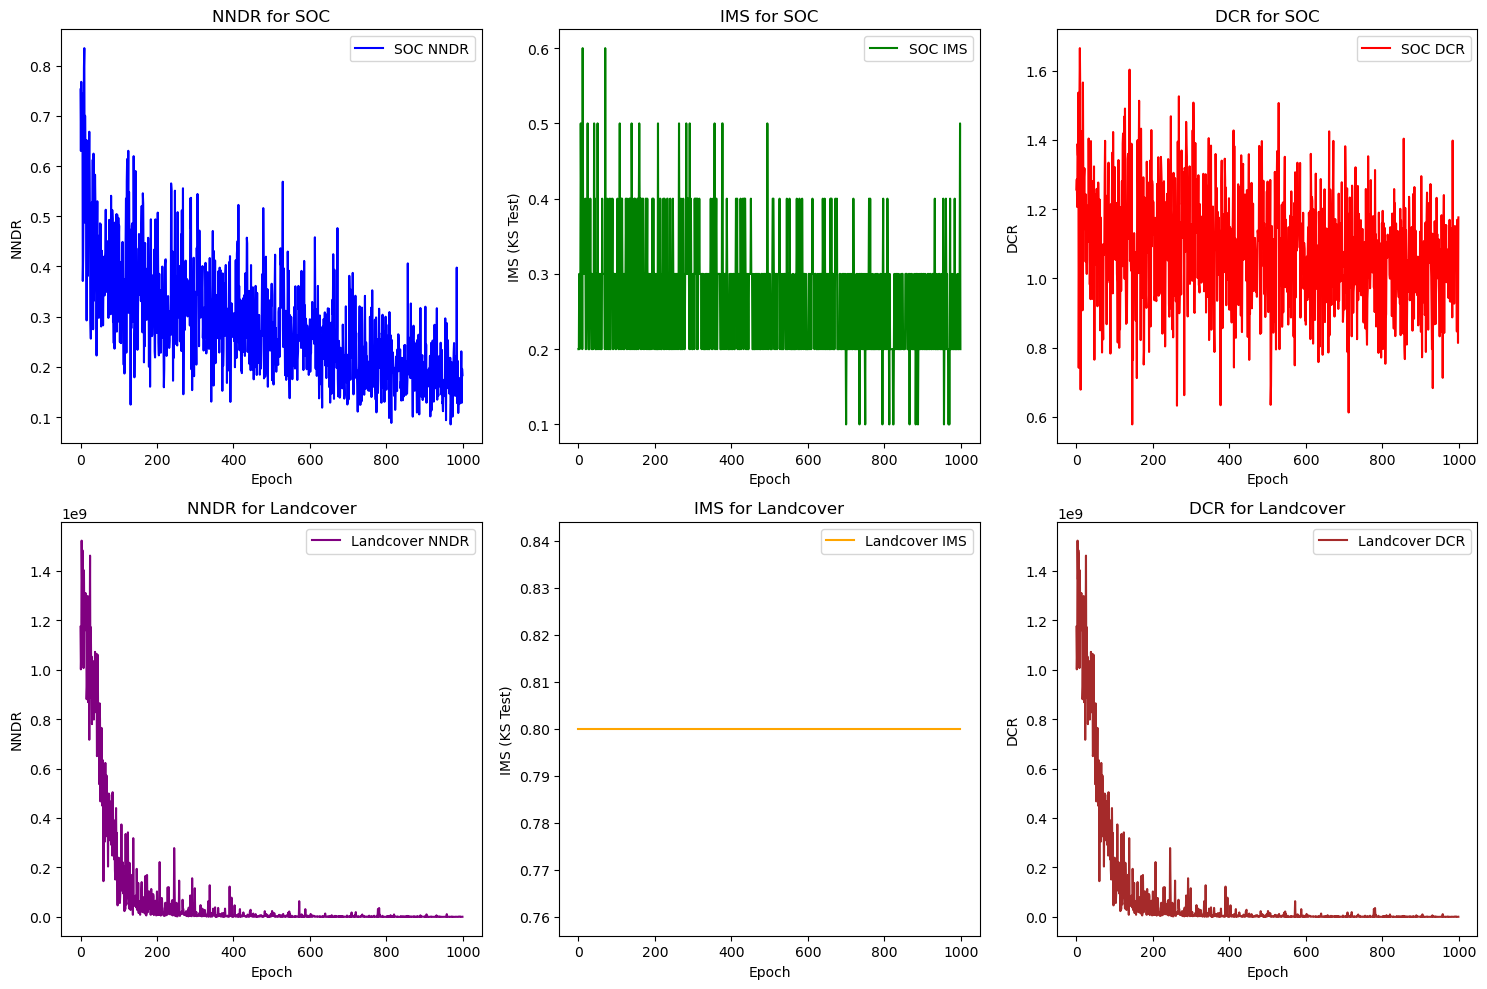

In [69]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp

# Define NNDR metric
def nndr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred) / (tf.abs(y_true) + 1e-10))  # Avoid division by zero

# Define IMS metric comparing distributions of generated and real samples
def ims_metric(real_samples, generated_samples):
    # Perform the Kolmogorov-Smirnov test to compare distributions
    stat, _ = ks_2samp(real_samples.numpy().flatten(), generated_samples.numpy().flatten())
    return stat  # Return the KS statistic as the IMS value

# Define DCR metric
def dcr_metric(y_true, y_pred):
    return tf.reduce_mean(y_pred / (y_true + 1e-10))  # Normalize by true values

# Parameters
noise_dim = 100  # Dimension of noise input
num_landcover_classes = landcover_onehot.shape[1]  # Number of landcover classes
epochs = 1000
batch_size = 10

# Initialize lists to store loss values and metric histories
d_loss_history = []
g_loss_history = []
nndr_history = []
ims_history = []
dcr_history = []
landcover_nndr_history = []
landcover_ims_history = []
landcover_dcr_history = []

# Create models
generator = build_generator_with_gumbel(noise_dim, num_landcover_classes)
discriminator = build_discriminator_with_gumbel(num_landcover_classes)

# Optimizers
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Define loss function
def loss_fn(real_soc, real_landcover, fake_soc_pred, landcover_logits):
    soc_loss = tf.reduce_mean(tf.square(real_soc - fake_soc_pred))
    class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=landcover_logits, labels=real_landcover))
    return soc_loss + class_loss

# Training
for epoch in range(epochs):
    for _ in range(len(reflectance) // batch_size):
        # Sample real data
        idx = np.random.choice(real_reflectance.shape[0], batch_size, replace=False)

        real_reflectance = tf.convert_to_tensor(reflectance[idx], dtype=tf.float32)  # Shape: (10, 234)
        soc_real = tf.convert_to_tensor(soc_values[idx], dtype=tf.float32)  # Shape: (10, 1)
        landcover_real = tf.convert_to_tensor(landcover_onehot[idx], dtype=tf.float32)  # Shape: (10, 5)

        # Generate noise
        noise = np.random.normal(0, 1, (batch_size, noise_dim)).astype(np.float32)

        # Generate fake data
        noise_tensor = tf.convert_to_tensor(noise, dtype=tf.float32)  # Convert noise to tensor
        fake_soc, landcover_logits = generator([noise_tensor, soc_real, landcover_real])  # fake_soc: (10, 1), landcover_logits: (10, 5)

        # Train Discriminator
        with tf.GradientTape() as tape:
            # Real data predictions
            real_soc_pred, landcover_logits_real = discriminator([real_reflectance, soc_real, landcover_real])
            d_loss_real = loss_fn(soc_real, landcover_real, real_soc_pred, landcover_logits_real)

            # Fake data predictions
            fake_landcover_onehot = gumbel_softmax(landcover_logits)  # Shape should be (10, num_landcover_classes)
            d_loss_fake = loss_fn(fake_soc, fake_landcover_onehot, fake_soc, landcover_logits)

            # Combine losses
            d_loss = d_loss_real + d_loss_fake

        # Calculate gradients and apply them
        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in grads]  # Clip gradients
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            # Generate noise for the generator
            noise = np.random.normal(0, 1, (batch_size, noise_dim)).astype(np.float32)
            noise_tensor = tf.convert_to_tensor(noise, dtype=tf.float32)  # Convert noise to tensor

            # Generate fake data
            fake_soc, landcover_logits = generator([noise_tensor, soc_real, landcover_real])  # Ensure correct inputs here

            # Calculate generator loss
            g_loss = loss_fn(soc_real, landcover_real, fake_soc, landcover_logits)  # Use fake_soc directly

        # Calculate gradients and apply them
        grads = tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # Save losses at the end of each epoch
    d_loss_history.append(d_loss.numpy())
    g_loss_history.append(g_loss.numpy())

    # Compute custom metrics for SOC
    nndr_value = nndr_metric(soc_real, fake_soc).numpy()
    ims_value = ims_metric(soc_real, fake_soc)  # Compare generated and real SOC distributions
    dcr_value = dcr_metric(soc_real, fake_soc).numpy()

    # Compute custom metrics for Landcover
    nndr_landcover = nndr_metric(landcover_real, fake_landcover_onehot).numpy()
    ims_landcover = ims_metric(landcover_real, fake_landcover_onehot)
    dcr_landcover = dcr_metric(landcover_real, fake_landcover_onehot).numpy()

    nndr_history.append(nndr_value)
    ims_history.append(ims_value)
    dcr_history.append(dcr_value)

    landcover_nndr_history.append(nndr_landcover)
    landcover_ims_history.append(ims_landcover)
    landcover_dcr_history.append(dcr_landcover)

    # Print losses and metrics for monitoring
    print(f'Epoch: {epoch}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}, SOC NNDR: {nndr_value}, SOC IMS: {ims_value}, SOC DCR: {dcr_value}, Landcover NNDR: {nndr_landcover}, Landcover IMS: {ims_landcover}, Landcover DCR: {dcr_landcover}')

# Plotting graphs
plt.figure(figsize=(15, 10))

# Plot NNDR for SOC
plt.subplot(2, 3, 1)
plt.plot(nndr_history, label='SOC NNDR', color='blue')
plt.xlabel('Epoch')
plt.ylabel('NNDR')
plt.title('NNDR for SOC')
plt.legend()

# Plot IMS for SOC
plt.subplot(2, 3, 2)
plt.plot(ims_history, label='SOC IMS', color='green')
plt.xlabel('Epoch')
plt.ylabel('IMS (KS Test)')
plt.title('IMS for SOC')
plt.legend()

# Plot DCR for SOC
plt.subplot(2, 3, 3)
plt.plot(dcr_history, label='SOC DCR', color='red')
plt.xlabel('Epoch')
plt.ylabel('DCR')
plt.title('DCR for SOC')
plt.legend()

# Plot NNDR for Landcover
plt.subplot(2, 3, 4)
plt.plot(landcover_nndr_history, label='Landcover NNDR', color='purple')
plt.xlabel('Epoch')
plt.ylabel('NNDR')
plt.title('NNDR for Landcover')
plt.legend()

# Plot IMS for Landcover
plt.subplot(2, 3, 5)
plt.plot(landcover_ims_history, label='Landcover IMS', color='orange')
plt.xlabel('Epoch')
plt.ylabel('IMS (KS Test)')
plt.title('IMS for Landcover')
plt.legend()

# Plot DCR for Landcover
plt.subplot(2, 3, 6)
plt.plot(landcover_dcr_history, label='Landcover DCR', color='brown')
plt.xlabel('Epoch')
plt.ylabel('DCR')
plt.title('DCR for Landcover')
plt.legend()

plt.tight_layout()
plt.show()


In [70]:
import matplotlib.pyplot as plt

# Save NNDR for SOC
plt.figure(figsize=(6, 4))
plt.plot(nndr_history, label='SOC NNDR', color='blue')
plt.xlabel('Epoch')
plt.ylabel('NNDR')
plt.title('NNDR for SOC')
plt.legend()
plt.tight_layout()
plt.savefig('nndr_soc.png', dpi=300)  # Save the NNDR graph as 'nndr_soc.png'
plt.close()  # Close the figure

# Save IMS for SOC
plt.figure(figsize=(6, 4))
plt.plot(ims_history, label='SOC IMS', color='green')
plt.xlabel('Epoch')
plt.ylabel('IMS (KS Test)')
plt.title('IMS for SOC')
plt.legend()
plt.tight_layout()
plt.savefig('ims_soc.png', dpi=300)  # Save the IMS graph as 'ims_soc.png'
plt.close()  # Close the figure

# Save DCR for SOC
plt.figure(figsize=(6, 4))
plt.plot(dcr_history, label='SOC DCR', color='red')
plt.xlabel('Epoch')
plt.ylabel('DCR')
plt.title('DCR for SOC')
plt.legend()
plt.tight_layout()
plt.savefig('dcr_soc.png', dpi=300)  # Save the DCR graph as 'dcr_soc.png'
plt.close()  # Close the figure


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Function to save and plot each metric
def plot_and_save(metric_data, title, ylabel, filename):
    plt.figure(figsize=(10, 6))
    plt.plot(metric_data, label=title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(filename)
    plt.close()  # Close the figure to free up memory

# Plot and save NNDR for Landcover
plot_and_save(np.array(landcover_nndr_history) * 1e-9, 'Landcover NNDR', 'NNDR', 'landcover_nndr.png')

# Plot and save IMS for Landcover
plot_and_save(landcover_ims_history, 'Landcover IMS', 'IMS (KS Test)', 'landcover_ims.png')

# Plot and save DCR for Landcover
plot_and_save(np.array(landcover_dcr_history) * 1e-9, 'Landcover DCR', 'DCR ', 'landcover_dcr.png')

# Optionally, show the plots in the same session (if needed)
# plt.show()
